# Startup

## IMPORTANT: 

Check:
- '4KW4'  # CRO .... chromophore - check this
- '8A6G'  # OHD... chromophore?
- '1M40' has A and B confirmations

## Imports

In [1]:
# ! pip install --upgrade jupyter ipywidgets
# ! conda install -c conda-forge -y ipywidgets
# ! jupyter nbextension enable --py widgetsnbextension

In [2]:
import os
import sys
import traceback
import re
import argparse
import shutil
import warnings
import copy
import datetime
from tqdm.auto import tqdm
import copy
import datetime
import numpy as np
import pandas as pd
import statsmodels.api as sm
import pickle
import shutil
import subprocess
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict

from pdbfixer import PDBFixer
from openmm.app import PDBFile

import kit
import kit.globals as G
from kit.log import log_info
from kit.path import join
from kit.data import DD, Split, str_to_file, file_to_str
from kit.maths import calc_entropy
from kit.plot import A4_width, A4_height, spider_plot, plot_text
from kit.hashes import str_to_hash
from kit.bioinf import AA1_STD, AA_CHARACTERISTICS_2a
from kit.bioinf.alignment.structure.tm_align import align_structures as tm_align_structures
from kit.bioinf.proteins import ProteinType
from kit.bioinf.proteins.utils import calc_seq_aa_cnts
from kit.bioinf.proteins.eval.destress import load_destress_csv
from kit.bioinf.pdb import get_similar_structures, pdb_to_seqs, download_pdb
from kit.bioinf.fasta import fastas_to_seqs, fasta_to_df
from kit.bioinf.proteins.eval import calc_sequence_recovery
from kit.bioinf.proteins.display import print_seq, print_seq_stats, calc_seq_aa_cnts
from kit.bioinf.proteins.plots import plot_aa_dist, plot_pwm_dist
from kit.bioinf.immuno.mhc_1 import Mhc1Predictor, MHC_1_PEPTIDE_LENGTHS
from kit.bioinf.immuno.utils import get_immuno_setup_hash, get_mhc_1_setup_hash
from kit.loch import view_structure, seq_hashes_to_file, file_to_seq_hashes
from kit.loch.update import Loch
from kit.loch.path import get_pdb_file_path, get_fasta_file_path
from kit.loch.utils import chains_to_seq, get_seq_hash
from kit.hashes import str_to_hash


import CAPE
from CAPE.Eval.MPNN.db import CapeMpnnDB
from CAPE.Eval.MPNN.general import generate_general
from CAPE.Eval.MPNN.specific import call_mpnn
from CAPE.Eval.MPNN.design import BestTrial, Design, set_config, reduce_dict
from CAPE.Eval.MPNN.plots import plot_hyp_search, plot_trade_off, plot_specific, \
    plot_spider_seq_aa_dist_gen_data_base, plot_info, plot_infos
from CAPE.Eval.MPNN.utils import sources_to_model_ids, download_specific_protein, \
    send_to_pdb, cp_pdb_to_dir_path, \
    c_avg_vis_mhc_1_v_g, c_avg_vis_mhc_1_pc_v_g, c_avg_rec_v_g, c_avg_tm_v_s, \
    c_avg_vis_mhc_1_v_s, c_avg_tm_t_s, c_avg_vis_mhc_1_t_s, \
    write_config_yaml, write_job_yaml
from CAPE.MPNN.overwrite import tied_featurize
from CAPE.MPNN.model import CapeMPNN
from CAPE.MPNN.data.utils import get_data_loaders_pdb, shutdown, \
    get_structure_data_sets, \
    get_preference_pairs, get_data_loader_preferences, get_avg_preference_score, \
    OMIT_AAs_NP, BIAS_AAs_NP
from CAPE.MPNN.ProteinMPNN.training.utils import StructureLoader
from CAPE.MPNN.ProteinMPNN.protein_mpnn_utils import _S_to_seq


from ipywidgets import interact

## Constants

In [3]:
person_mhc_1_alleles = "HLA-A*02:01+HLA-A*24:02+HLA-B*07:02+HLA-B*39:01+HLA-C*07:01+HLA-C*16:01"
immuno_setup = {"mhc_1": person_mhc_1_alleles}

In [4]:
design_epitope_window = 0
design_anchors_window = 0

In [5]:
general_args = DD.from_dict({
    'rescut': 3.5,
    'debug': False,
    'max_protein_length': 2000,
    'multithreading': False,
    'batch_size': 2000,
    'temerature': 0.000001,
    'num_examples_per_epoch': 1000000
})

In [6]:
CAPE.Eval.MPNN.plots.set_colors("blue", "red", {
    "e32b8ed0": "orange", 
    "458340e4": "pink"
}, "red")
CAPE.Eval.MPNN.plots.set_markers('.', 'o', {
    2: 'v', 
    10: 's', 
    20: 'p'}
)

In [7]:
RELOAD_BATCHES = False
RELOAD_SIMILAR = False

save_fig = True
run_proteome = False
write_yamls = False
write_job_yamls = False
nr_specific_trials = 3
specific_trials = list(range(1, 1+nr_specific_trials))

bt = BestTrial.TM_NINETY_MIN_VIS
bt.mhc_1_key = None  # defined below after initialization of predictor
bt_pop = BestTrial.MAX_TM

epochs = [2, 10, 20]
epochs_selected = [10, 20]

# Population
coverages = [5, 10, 50, 90]
mhc_1_coverages = [f'min_coverage_{c}pc' for c in coverages]

In [8]:
col_id_str = ['base_model_name', 'mhc_1_predictor', 'proteome_file_name']
col_id_num = ['beta', 'reload_data_every_n_epochs',
      'temperature', 'lr', 'num_examples_per_epoch', 'batch_size',
      'max_protein_length', 'rescut']

In [9]:
destress_number_names = [
    'dssp edit dist', 'delta rosetta total', 'delta hydrophobic fitness', 'delta packing density',
    'delta aggrescan3d total', 'delta dfire2 total', 'delta evoef2 total', 'isoelectric point'
]

infos_to_plot = {
    # info: axis label
    'dssp': 'dssp edit dist',
    'rosetta_total': 'delta rosetta total', 
    'hydrophobic_fitness': 'delta hydrophobic fitness', 
    'packing_density': 'packing density',
    'aggrescan3d_avg': 'delta aggrescan3d avg', 
    'aggrescan3d_max': 'delta aggrescan3d max', 
    # 'dfire2_total': 'delta dfire2 total', 
    # 'evoef2_total': 'evoef2 total', 
    'isoelectric_point': 'isoelectric point',
    'blosum': 'BLOSUM-62 score', 
}

## Load framework

In [10]:
# Enable LaTeX text rendering
plt.rcParams['text.usetex'] = True

In [11]:
loch = Loch()
best = {}
GO_vectors = {}

In [12]:
mhc_1_setup_hash = get_mhc_1_setup_hash(immuno_setup['mhc_1'])
immuno_setup_hash = get_immuno_setup_hash(immuno_setup)

In [13]:
protein_infos = {
        "2R4U": ("Crystal Structure of Wild-type E.coli GS in complex with ADP and Glucose - Escherichia coli", ProteinType.MONOMER),
        "5BX2": ("GH116 beta-glucosidase with 2-deoxy-2-fluoroglucoside - Thermoanaerobacterium xylanolyticum", ProteinType.MONOMER),
        #"2I88": ("Channel-forming Domain of Colicin E1 - Escherichia coli", ProteinType.MONOMER),
        #"4W5Z": ("Catalytic domain of Chitinase 60 - Moritella marina", ProteinType.MONOMER),
        #"1ECA": ("Erythrocruorin - Chironomus thummi", ProteinType.MONOMER),
        #"3QD7": ("YdaL - Escherichia coli", ProteinType.MONOMER),
        #"5ONN": ("Ectoine Synthase - Paenibacillus lautus", ProteinType.MONOMER),
        "3X2G": ("PcCel45A N92D apo form at 100 - Phanerodontia chrysosporium", ProteinType.MONOMER),
        "2EID": ("Galactose Oxidase W290G mutant - Fusarium graminearum", ProteinType.MONOMER),
        # "3MIL": ("Isoamyl acetate-hydrolyzing esterase - Saccharomyces cerevisiae", ProteinType.HOMOOLIGOMER),
        # "6R5X": ("8-bladed beta-propeller formed by four 2-bladed fragments - Nostoc punctiforme", ProteinType.HOMOOLIGOMER),
        "4RGD": ("The structure a AS-48 G13K/L40K mutant - Enterococcus faecalis", ProteinType.HOMOOLIGOMER),
        "3BBE": ("Nep1 - Methanocaldococcus jannaschii", ProteinType.HOMOOLIGOMER),
        "4KW4": ("Green Fluorescent Protein - Aequorea victoria", ProteinType.MONOMER), 
        "8A6G": ("Green Fluorescent Protein OFF - Aequorea victoria", ProteinType.MONOMER),
        "1UBQ": ("Ubiquitin - Homo sapiens, Uniprot: P0CG48 (exact)", ProteinType.MONOMER),
        "2QMT": ("GB1 - Staphylococcus aureus, Uniprot: P19909", ProteinType.MONOMER), 
        "6QJI": ("Crystal Structure of the third PDZ domain of PSD-95 protein - Homo sapiens, Uniprot: P78352 (exact, partly unmodelled)", ProteinType.HOMOOLIGOMER),  # seqs differ in file
        "1M40": ("TEM-1", ProteinType.MONOMER),
        "5O75": ("Ube4B U-box domain", ProteinType.MONOMER),
        #"7V4V": ("Ferritin - Thermotoga maritima, Uniprot: Q9X0L2", ProteinType.COMPLEX),  # just always made problems
        "7DYA": ("Ferritin - Thermotoga maritima, Uniprot: Q9X0L2", ProteinType.HOMOOLIGOMER),
        "1SQ3": ("Ferritin - Archaeoglobus fulgidus, Uniprot: O29424", ProteinType.HOMOOLIGOMER), #(contains MSE amino acid - not standard)
        "1EUM": ("Ferritin - Escherichia coli, Uniprot: P0A998", ProteinType.HOMOOLIGOMER),
        "1QAW": ("TRAP - Geobacillus stearothermophilus, Uniprot: Q9X6J6", ProteinType.HOMOOLIGOMER),  # seqs differ in file
        "4GYT": ("pg0076 protein - Legionella pneumophila", ProteinType.HOMOOLIGOMER),
        "6EHB": ("OmpU, an outer membrane protein - Vibrio cholerae", ProteinType.HOMOOLIGOMER),  # seqs differ in file
}

d_pdb_to_seqs_kwargs = {
    '1SQ3': {
        'aa_ids': [' ', 'H_MSE'],
        'aa3_replace': {'MSE': 'MET'},
    }
}

protein_splits = {
    Split.VAL: ["2R4U", "5BX2", "3X2G", "2EID", "4RGD", "3BBE"],
    Split.TEST: [
        "4KW4", "8A6G",  # GFPs
        "1UBQ",
        "2QMT", "6QJI", "1M40", "5O75",  # from METL-paper
        "7DYA", "1SQ3", "1EUM",  # Ferritin
        "1QAW",  # Transcription attenuation protein
        "4GYT", "6EHB",  # ProteinMPNN examples
    ]
}

specific_proteins = {}
for s, prots in protein_splits.items():
    specific_proteins[s] = {}
    for p in prots:
        specific_proteins[s][p] = protein_infos[p]

In [14]:
df_specific_proteins = pd.concat([    
    pd.DataFrame({pdb_id: (*info, split) for pdb_id, info in specific_proteins[split].items()}).transpose()
    for split in [Split.VAL, Split.TEST]])

df_specific_proteins.index.name = 'pdb_id'
df_specific_proteins.columns=['name', 'protein type', 'split']
df_specific_proteins

,name,protein type,split
pdb_id,,,
2R4U,Crystal Structure of Wild-type E.coli GS in co...,monomer,VAL
5BX2,GH116 beta-glucosidase with 2-deoxy-2-fluorogl...,monomer,VAL
3X2G,PcCel45A N92D apo form at 100 - Phanerodontia ...,monomer,VAL
2EID,Galactose Oxidase W290G mutant - Fusarium gram...,monomer,VAL
4RGD,The structure a AS-48 G13K/L40K mutant - Enter...,homooligomer,VAL
3BBE,Nep1 - Methanocaldococcus jannaschii,homooligomer,VAL
4KW4,Green Fluorescent Protein - Aequorea victoria,monomer,TEST
8A6G,Green Fluorescent Protein OFF - Aequorea victoria,monomer,TEST
1UBQ,"Ubiquitin - Homo sapiens, Uniprot: P0CG48 (exact)",monomer,TEST


In [15]:
args, args_unknown = kit.init('CAPE', 'CAPE-Eval', create_job=False, arg_string=None)

Startup with args: Namespace(task='', job='AUTO', domain='d', env='py', device='cuda', debug=None, project_path=None, loch_path=None) Load .env file
2024-09-02 15:59:34:  Using CUDA device: NVIDIA GeForce RTX 3070 Ti
                      Number of CUDA devices: 1
                      Current CUDA device: 0
                      CUDA version: 11.7
                      PyTorch version: 2.0.1+cu117
                      cuDNN version: 8500
ENV.PROJECT: '/media/thoth/FILES/study/ed/PhD/projects/cape'
2024-09-02 15:59:34:  WARNING: TASK NOT SPECIFIED
2024-09-02 15:59:34:  Start CAPE-None-None on py using cuda
2024-09-02 15:59:34:  G.ENV
2024-09-02 15:59:34:  PROJECT   ... /media/thoth/FILES/study/ed/PhD/projects/cape
2024-09-02 15:59:34:  ID        ... py
2024-09-02 15:59:34:  KIT       ... /media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/kit
2024-09-02 15:59:34:  RAW       ... /media/thoth/FILES/study/ed/PhD/projects/cape/data/raw
2024-09-02 15:59:34:  INPUT     ... /media/thoth/

In [16]:
def add_to_GO_vectors(seq_hashes, predictor_structure_name):
    global GO_vectors
    
    for seq_hash in [s for s in seq_hashes if s is not None]:
        go_function_file_path = kit.loch.path.get_function_path(
            seq_hash,
            predictor_structure_name=predictor_structure_name)
        if os.path.exists(go_function_file_path) and seq_hash not in GO_vectors:
            df = pd.read_csv(go_function_file_path, sep=' ', names= ['structure', 'GO_term', 'score']).sort_values('GO_term').set_index('GO_term')
            df = df[['score']].rename(columns={'score': seq_hash})
            GO_vectors[seq_hash] = df
            
    df_GO_vectors = pd.concat(list(GO_vectors.values()), axis=1).transpose()
    df_GO_vectors.index.name='seq_hash'
    return df_GO_vectors

### Set paths

In [17]:
# set paths

eval_path = join(G.ENV.PROJECT, "artefacts", "CAPE-MPNN", "eval")

CapeMPNN.base_model_pt_dir_path = os.path.join(G.ENV.INPUT, "CAPE-MPNN", "vanilla_model_weights")
CapeMPNN.base_model_yaml_dir_path = os.path.join(G.ENV.INPUT, 'CAPE-MPNN', 'base_hparams')

data_path = os.path.join(G.ENV.INPUT, "CAPE-MPNN", "pdb_2021aug02")
loch_path = os.path.join(G.ENV.PROJECT, "artefacts", "CAPE-MPNN", 'loch')
colabfold_path = os.path.join(G.ENV.ARTEFACTS, 'colabfold')

destress_dir_path = os.path.join(G.ENV.ARTEFACTS, 'CAPE-MPNN', 'destress')

kit.loch.path.set_loch_path(loch_path)

pdb_input_path = join(G.PROJECT_ENV.INPUT, 'CAPE-MPNN', 'pdb')
fasta_output_path = join(G.ENV.PROJECT,  'artefacts', 'CAPE-MPNN', 'outputs', 'fasta')
cape_mpnn_model_dir_path = os.path.join(G.ENV.PROJECT, "artefacts", "CAPE-MPNN", "models")
netmhcpan_dir_path = join(G.ENV.ARTEFACTS, "CAPE-MPNN", "immuno", "mhc_1", "netmhcpan")

### Load Immuno-Predictors

In [18]:
predictor_MHC_I_netmhcpan_dd = DD.from_yaml(
    os.path.join(
        G.PROJECT_ENV.CONFIG, 
        'immuno', 
        'mhc_1_predictor', 
        f'netmhcpan.yaml'
    )
)

predictor_MHC_I_netmhcpan_args = {
    'data_dir_path': netmhcpan_dir_path,
    'limit': predictor_MHC_I_netmhcpan_dd.PREDICTOR_MHC_I.LIMIT,
}
if "LIMIT_CALIBRATION" in predictor_MHC_I_netmhcpan_dd.PREDICTOR_MHC_I:
    predictor_MHC_I_netmhcpan_args.update({'limit_calibration': predictor_MHC_I_netmhcpan_dd.PREDICTOR_MHC_I.LIMIT_CALIBRATION})
predictor_MHC_I_netmhcpan = Mhc1Predictor.get_predictor(predictor_MHC_I_netmhcpan_dd.PREDICTOR_MHC_I.NAME)(**predictor_MHC_I_netmhcpan_args)

2024-09-02 15:59:34:  Init <class 'kit.bioinf.immuno.mhc_1._netmhcpan.Mhc1PredictorNetMhcPan'> MHC-Class1 predictor
2024-09-02 15:59:34:  Loading HLA-B*13:02 from percentile_HLA_B_13_02.tsv
2024-09-02 15:59:34:  Loading HLA-A*26:08 from percentile_HLA_A_26_08.tsv
2024-09-02 15:59:34:  Loading HLA-A*02:22 from percentile_HLA_A_02_22.tsv
2024-09-02 15:59:34:  Loading HLA-A*66:01 from percentile_HLA_A_66_01.tsv
2024-09-02 15:59:34:  Loading HLA-B*48:01 from percentile_HLA_B_48_01.tsv
2024-09-02 15:59:34:  Loading HLA-C*04:01 from percentile_HLA_C_04_01.tsv
2024-09-02 15:59:34:  Loading HLA-B*15:35 from percentile_HLA_B_15_35.tsv
2024-09-02 15:59:35:  Loading HLA-A*30:01 from percentile_HLA_A_30_01.tsv
2024-09-02 15:59:35:  Loading HLA-B*35:12 from percentile_HLA_B_35_12.tsv
2024-09-02 15:59:35:  Loading HLA-A*74:01 from percentile_HLA_A_74_01.tsv
2024-09-02 15:59:35:  Loading HLA-C*15:09 from percentile_HLA_C_15_09.tsv
2024-09-02 15:59:35:  Loading HLA-C*15:02 from percentile_HLA_C_15_02.

In [19]:
predictor_MHC_I_pwm_dd = DD.from_yaml(
    os.path.join(
        G.PROJECT_ENV.CONFIG, 
        'immuno', 
        'mhc_1_predictor', 
        f'pwm_dynamic.yaml'
    )
)

predictor_MHC_I_dd_args = {
    'data_dir_path': predictor_MHC_I_pwm_dd.PREDICTOR_MHC_I.FOLDER, 
    'limit': predictor_MHC_I_pwm_dd.PREDICTOR_MHC_I.LIMIT,
}
if "LIMIT_CALIBRATION" in predictor_MHC_I_pwm_dd.PREDICTOR_MHC_I:
    predictor_MHC_I_dd_args['limit_calibration'] = predictor_MHC_I_pwm_dd.PREDICTOR_MHC_I.LIMIT_CALIBRATION
predictor_MHC_I_pwm = Mhc1Predictor.get_predictor(predictor_MHC_I_pwm_dd.PREDICTOR_MHC_I.NAME)(**predictor_MHC_I_dd_args)

2024-09-02 16:00:05:  Init <class 'kit.bioinf.immuno.mhc_1._pwm.Mhc1PredictorPwm'> MHC-Class1 predictor


In [20]:
predictors_MHC_I = {
    'netMHCpan': predictor_MHC_I_netmhcpan,
    'pwm': predictor_MHC_I_pwm
}

In [21]:
predictor_setup = {'mhc_1': predictor_MHC_I_netmhcpan}

In [22]:
db = CapeMpnnDB(os.path.join(G.ENV.ARTEFACTS, "DBs", 'cape_mpnn.db'), predictor_MHC_I_netmhcpan)
CAPE.Eval.MPNN.design.db = db

In [23]:
#db.create_database()

In [24]:
#set_config(db, nr_specific_trials, CAPE.Eval.MPNN.pdbs_to_exclude)

In [25]:
bt.mhc_1_key = (immuno_setup['mhc_1'], predictor_MHC_I_netmhcpan.get_predictor_hash(), None)

In [26]:
CAPE.Eval.MPNN.init(db, loch)

In [27]:
def repair_for_destress(pdb_file_path):
    fixer = PDBFixer(filename=pdb_file_path)
    fixer.removeHeterogens(keepWater=False)
    fixer.findMissingResidues()
    fixer.findMissingAtoms()
    fixer.addMissingAtoms()
    fixer.addMissingHydrogens()
    PDBFile.writeFile(fixer.topology, fixer.positions, open(pdb_file_path, 'w'))

## Read CAPE-MPNN trained checkpoints

In [28]:
df_models = {
    "model_id": [],
    "success": [],
    "mhc_1_alleles": [],
    "proteome_file_name": [],
    "base_model_name": [],
    "reload_data_every_n_epochs": [],
    "preference_sampling_method": [],
    "beta": [],
    "temperature": [],
    "lr": [],
    "num_examples_per_epoch": [],
    "batch_size": [],
    "max_protein_length": [],
    "mhc_1_predictor": [],
    "rescut": [],
    "start": [],
}

df_ckpts = {
    'model_id': [],
    "ckpt_id": [],
    "success": [],
    "epoch": [],
    'job_id': [],
}

def _get(dpo_hparams_dd, info):
    if dpo_hparams_dd and info in dpo_hparams_dd:
        return dpo_hparams_dd[info]


for model_id in os.listdir(cape_mpnn_model_dir_path):
    model_dir_path = os.path.join(cape_mpnn_model_dir_path, model_id)
    dpo_hparams_file_path = os.path.join(model_dir_path, "dpo_hparams.yaml")

    if os.path.exists(dpo_hparams_file_path):
        dpo_hparams_dd = DD.from_yaml(dpo_hparams_file_path)
        df_models['model_id'].append(model_id)
        df_models['mhc_1_alleles'].append(_get(dpo_hparams_dd, 'mhc_1_alleles'))
        df_models['proteome_file_name'].append(_get(dpo_hparams_dd, 'proteome_file_name'))
        df_models['base_model_name'].append(_get(dpo_hparams_dd, 'base_model_name'))
        df_models['reload_data_every_n_epochs'].append(_get(dpo_hparams_dd, 'reload_data_every_n_epochs'))
        df_models['preference_sampling_method'].append(_get(dpo_hparams_dd, 'preference_sampling_method'))
        df_models['beta'].append(_get(dpo_hparams_dd, 'beta'))
        df_models['temperature'].append(_get(dpo_hparams_dd, 'temperature'))
        df_models['lr'].append(_get(dpo_hparams_dd, 'lr'))
        df_models['num_examples_per_epoch'].append(_get(dpo_hparams_dd, 'num_examples_per_epoch'))
        df_models['batch_size'].append(_get(dpo_hparams_dd, 'batch_size'))
        df_models['max_protein_length'].append(_get(dpo_hparams_dd, 'max_protein_length'))
        df_models['mhc_1_predictor'].append(_get(dpo_hparams_dd, 'mhc_1_predictor'))
        df_models['rescut'].append(_get(dpo_hparams_dd, 'rescut'))
        df_models['start'].append(datetime.datetime.fromtimestamp(os.path.getmtime(model_dir_path)))

        model_success = True
        for epoch in epochs:
            ckpt_file_path = os.path.join(model_dir_path, 'ckpts', f"epoch_{epoch}.pt")
            df_ckpts['model_id'].append(model_id)
            df_ckpts['ckpt_id'].append(f"{model_id}:epoch_{epoch}")
            df_ckpts['epoch'].append(epoch)

            if os.path.exists(ckpt_file_path):
                df_ckpts['success'].append(True)
                job_file_path = os.path.join(model_dir_path, 'jobs', 'ckpts', f"epoch_{epoch}.txt")               
            else:        
                model_success = False
                df_ckpts['success'].append(False)
                job_file_path = os.path.join(model_dir_path, 'jobs', 'ckpts', f"last.txt")
    
            df_ckpts['job_id'].append(file_to_str(job_file_path))
        df_models['success'].append(model_success)

df_models_all = pd.DataFrame(df_models).set_index("model_id")
df_ckpts = pd.DataFrame(df_ckpts).set_index("ckpt_id")

In [29]:
df_models_alternative_sampling = df_models_all.query('not preference_sampling_method.isnull()').copy()

In [30]:
df_models = df_models_all.query(f"lr > 1e-7 and preference_sampling_method.isnull()")

In [31]:
def get_ckpt_ids(df_models, successful_ckpts=None, successful_models=None):
    _df = df_ckpts.join(df_models['success'], how='inner', on='model_id', rsuffix='_mod')
    qry = []
    if successful_ckpts is not None:
        qry.append("success" if successful_ckpts else "not success")

    if successful_models is not None:
        qry.append("success_mod" if successful_models else "not success_mod")

    if len(qry) > 0:
        _df = _df.query(" and ".join(qry))
    
    return _df.index.to_list() 

In [32]:
df_models_hyp = df_models.query(f"mhc_1_alleles == '{mhc_1_setup_hash}' and proteome_file_name.isnull()")
df_models_proteome = df_models.query(f"mhc_1_alleles == '{mhc_1_setup_hash}' and not proteome_file_name.isnull()")
df_models_population = df_models.query(f"mhc_1_alleles in  {mhc_1_coverages} and proteome_file_name.isnull()")

df_ckpts_hyp = df_ckpts[df_ckpts['model_id'].isin(df_models_hyp.index)]
df_ckpts_proteome = df_ckpts[df_ckpts['model_id'].isin(df_models_proteome.index)]
df_ckpts_population = df_ckpts[df_ckpts['model_id'].isin(df_models_population.index)]

In [33]:
ckpt_ids_hyp = get_ckpt_ids(df_models_hyp, successful_ckpts=True, successful_models=True)
ckpt_ids_proteome = get_ckpt_ids(df_models_proteome, successful_ckpts=True, successful_models=True)
ckpt_ids_population = get_ckpt_ids(df_models_population, successful_ckpts=True, successful_models=True)

ckpt_ids_base = list(set(sum([_df.base_model_name.to_list() for _df in [df_models_hyp, df_models_proteome, df_models_population]], [])))

ckpt_ids_to_load = ckpt_ids_hyp + ckpt_ids_proteome + ckpt_ids_population

ckpt_ids_generate_general = ckpt_ids_hyp + ckpt_ids_base
ckpt_ids_generate_special_val = ckpt_ids_hyp + ckpt_ids_base
ckpt_ids_generate_special_test = ckpt_ids_base + ckpt_ids_proteome + ckpt_ids_population

In [34]:
print(f"{len(df_models_hyp.query('success'))} hyp search models successful")
print(f"{len(df_models_hyp.query('not success'))} hyp search models failed")
print(f"{len(ckpt_ids_hyp)} successful hyp search ckpts")

17 hyp search models successful
4 hyp search models failed
51 successful hyp search ckpts


In [35]:
df_models_hyp.sort_values("beta")

,success,mhc_1_alleles,proteome_file_name,base_model_name,reload_data_every_n_epochs,preference_sampling_method,beta,temperature,lr,num_examples_per_epoch,batch_size,max_protein_length,mhc_1_predictor,rescut,start
model_id,,,,,,,,,,,,,,,
78b6cb1a,True,b69bb1,None,v_48_020,2,None,0.001191,0.703717,1.418886e-07,1000000,10000,10000,pwm_dynamic,3.5,2024-04-13 19:38:08.296246
60103fbe,True,b69bb1,None,v_48_020,2,None,0.001740,0.447719,6.000184e-04,1000000,10000,10000,pwm_dynamic,3.5,2024-04-10 00:33:14.235194
2d67870e,True,b69bb1,None,v_48_020,2,None,0.001746,0.916712,8.225922e-04,1000000,10000,10000,pwm_dynamic,3.5,2024-04-04 17:59:16.121615
b5d1eab1,True,b69bb1,None,v_48_020,2,None,0.001818,0.811254,6.178679e-06,1000000,10000,10000,pwm_dynamic,3.5,2024-03-30 06:11:56.650953
e4058a5a,True,b69bb1,None,v_48_020,2,None,0.001975,0.721671,2.647420e-04,1000000,10000,10000,pwm_dynamic,3.5,2024-04-04 08:04:22.862680
6f1dbbb0,True,b69bb1,None,v_48_020,2,None,0.002057,0.885791,4.690145e-07,1000000,10000,10000,pwm_dynamic,3.5,2024-04-10 12:57:18.969104
3246eab2,True,b69bb1,None,v_48_020,2,None,0.002996,0.120930,2.167457e-06,1000000,10000,10000,pwm_dynamic,3.5,2024-04-14 16:20:16.163576
50534943,True,b69bb1,None,v_48_020,2,None,0.003538,0.315153,2.762203e-05,1000000,10000,10000,pwm_dynamic,3.5,2024-04-10 00:19:56.196738
53f01a6c,True,b69bb1,None,v_48_020,2,None,0.004181,0.219200,3.717371e-06,1000000,10000,10000,pwm_dynamic,3.5,2024-04-04 05:34:14.745961


### explore hyp-parameters

In [36]:
import warnings

# To ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

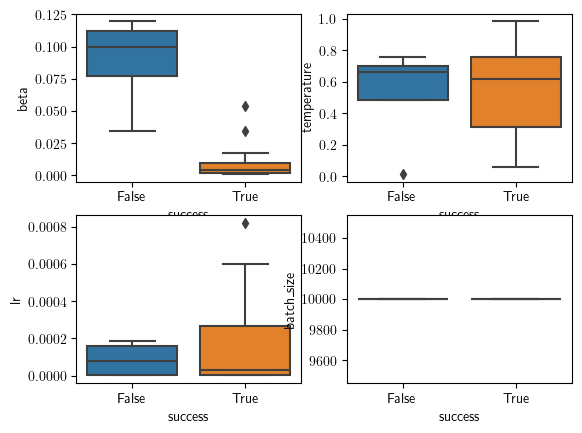

In [37]:
# Success vs beta
fig = plt.figure()
n_rows = 2
n_cols = 2
idx = 0
hyp_params = ['beta', 'temperature', 'lr', 'batch_size']

for hyp_param in hyp_params:
    idx += 1
    ax = fig.add_subplot(n_rows, n_cols, idx)
    sns.boxplot(ax=ax, data=df_models_hyp, x='success', y=hyp_param)

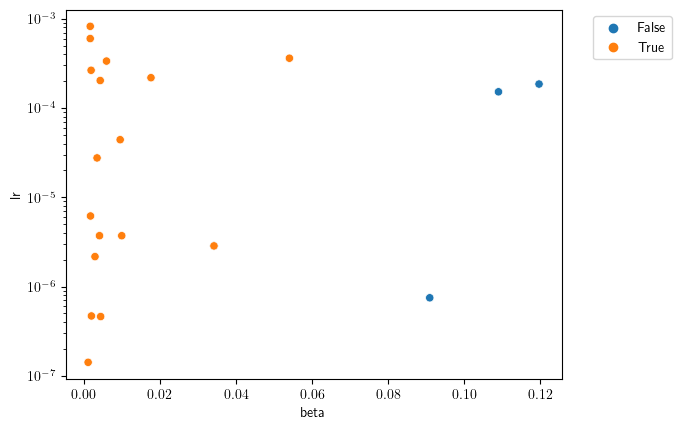

In [38]:
# learning rate vs. beta
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
sns.scatterplot(ax=ax, data=df_models_hyp, x='beta', y='lr', hue='success')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

### Load checkpoints

In [39]:
kit.DEVICE = 'cpu'

In [40]:
def load_CapeMPNN_ckpt(ckpt_id):
    model_id, ckpt = ckpt_id.split(':')
    return CapeMPNN.from_file(os.path.join(cape_mpnn_model_dir_path, model_id, 'ckpts', f"{ckpt}.pt"))

def load_CapeMPNN_ckpts(ckpt_ids):
    ckpts, base_model_ids = {}, set()

    for ckpt_id in ckpt_ids:
        ckpts[ckpt_id] = load_CapeMPNN_ckpt(ckpt_id)
        ckpts[ckpt_id].eval()
        base_model_name = ckpts[ckpt_id].base_model_name
        if base_model_name not in ckpts:
            ckpts[base_model_name] = CapeMPNN.from_file(base_model_name)
            ckpts[base_model_name].eval()
            base_model_ids.add(base_model_name)

    return ckpts, base_model_ids

In [41]:
ckpts, base_model_ids = load_CapeMPNN_ckpts(ckpt_ids_to_load)

In [42]:
base_model_ids = sorted(list(base_model_ids))
CAPE.Eval.MPNN.plots.base_model_ids = base_model_ids

In [43]:
ckpt_ids_ordered = base_model_ids + ckpt_ids_hyp
source_ids_ordered = ['data'] + ckpt_ids_ordered
# ckpt_names = base_model_ids + ckpt_ids

## Load structure data

### general

In [44]:
if RELOAD_BATCHES:
    data_loaders_pdb = get_data_loaders_pdb(data_path, [Split.VAL, Split.TEST], general_args.rescut, general_args.debug)

    data_sets_structure = get_structure_data_sets(
        data_loaders_pdb, 
        general_args.max_protein_length, 
        general_args.num_examples_per_epoch, 
        general_args.multithreading
    )
    
    data_loaders_structure = {
        split: StructureLoader(
                data_sets_structure[split], 
                batch_size=general_args.batch_size
        ) for split in [Split.VAL, Split.TEST]
    }

In [45]:
eval_batches = defaultdict(lambda: [])

for split in [Split.VAL, Split.TEST]:
    batches_file_path = os.path.join(eval_path, 'general', f"batches_{split}.pt")
    if not RELOAD_BATCHES:
        log_info("Load batches")
        eval_batches[split] = torch.load(batches_file_path)
    else:
        log_info("Save batches")
        for batch in tqdm(data_loaders_structure[split]):
            X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, \
                        visible_list_list, masked_list_list, masked_chain_length_list_list, \
                        chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, \
                        tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, \
                        bias_by_res_all, tied_beta = tied_featurize(batch, kit.DEVICE, None)
    
            randn_2 = torch.randn(chain_M.shape, device=X.device)
            eval_batches[split].append({
                'names': [b['name'] for b in batch],
                'batch': batch,
                'tied_featurize': 
                    (X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask, general_args.temperature, OMIT_AAs_NP, 
                     BIAS_AAs_NP, chain_M_pos, omit_AA_mask, bias_by_res_all)
            })
    
        torch.save(eval_batches[split], batches_file_path)

2024-09-02 16:00:09:  Load batches
2024-09-02 16:00:11:  Load batches



    'X': The coordinates of the backbone (N, $C_\alpha$, C, O)
    'S': The AA indices 
    'mask': is 1. where there are coordinates available in X (X was set to 0. where it was infinite)
    'chain_M': is 1. at positions that need to be designed because this chain has to be desinged
    'chain_encoding_all': for each position, has the number of the chain it belongs to
    'chain_M_pos': is 1. at positions that need to be designed because they are not fixed 
        (e.g. the chain can be designed, but some residues are fixed)
    'omit_AA_mask': seems like this is 1 if a certain AA should NOT be sampled at a position
    'residue_idx': index of the residues, starting at 0, there is an increase by 101 between chains, 
        the index is -100 for padded positions
    'bias_by_res_all': zero where probabilities of residues are not 'tweaked'


In [46]:
def S_to_seq(S):
    alphabet = 'ACDEFGHIKLMNPQRSTVWYX'
    seq = ''.join([alphabet[c] for c in S.tolist()])
    return seq

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

<Axes: ylabel='Count'>

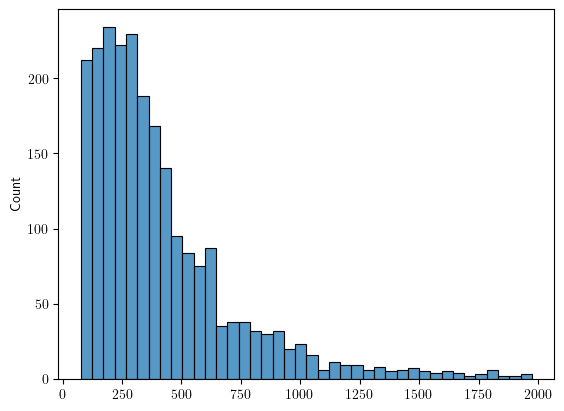

In [47]:
# get all sequences in the data
_all_seqs = {}
for split in tqdm([Split.VAL, Split.TEST]):
    for j, d_batch in tqdm(enumerate(eval_batches[split]), leave=False):
        batch = d_batch['tied_featurize']
        names = d_batch['names']
        X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask, \
            temperature, omit_AAs_np, bias_AAs_np, chain_M_pos, \
            omit_AA_mask, bias_by_res_all = batch
        batch_size = S.shape[0]
        for b in range(batch_size):
            seq = S_to_seq(S[b])  #, mask[b])
            _all_seqs[names[b]] = seq

# show the distribution of sequences in the data
sns.histplot([len(seq) for seq in _all_seqs.values()])

In [48]:
for k, v in _all_seqs.items():
    x = len([c for c in v if c == 'X'])
    if x > 0:
        print(f"{k}: {x}/{len(v)}")

5vte_A: 6/181
5eoj_C: 6/181
2omk_A: 2/450
1joj_B: 8/980
6q5o_A: 8/129
5f0o_A: 103/1155
5me3_A: 28/1171
5fc3_B: 1/620
4z89_G: 2/95
3pif_A: 38/1149
6ofl_A: 1/244
4pnd_C: 5/159
3cay_I: 32/216
4dac_C: 6/92
3f86_B: 40/136
5d62_A: 4/597
6zt1_D: 12/192
5u1m_A: 1/116
5btr_A: 2/402
3fho_A: 286/1016
7boa_C: 8/130
1hlm_A: 2/320


### specific

In [140]:
# download specific proteins
Design.designs = {}
pdb_models = {}
for split in [Split.VAL, Split.TEST]:
    for protein_id in protein_splits[split]:
        protein_name, protein_type = protein_infos[protein_id]
        pdb_models[protein_id], _seq_hash = download_specific_protein(protein_id, protein_type, pdb_input_path, 
                                                              d_pdb_to_seqs_kwargs=d_pdb_to_seqs_kwargs)

#### DESTRESS

In [50]:
_destress_dir_path = join(destress_dir_path, str(Split.TEST), 'data')

# copy pdb files to the DESTRESS folder
cp_pdb_to_dir_path(
    ['data'], 
    protein_splits[Split.TEST], 
    _destress_dir_path, 
    predictor_structure_name='exp'
)

# run the following command
print(f"python3 run_destress_headless.py --i {_destress_dir_path}")

Found/copied/missing: 13/0/0
[]
python3 run_destress_headless.py --i /media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/CAPE-Eval/CAPE-MPNN/destress/TEST/data


In [51]:
# repair_for_destress(os.path.join(_destress_dir_path, '6fff33543fed212bd5676344aa1a4a321913f0542054f1252b325270e1694a1e_exp.pdb'))

In [52]:
# load results into Designs
_ = Design.load_destress(['data'], list(Design.designs['data'].keys()), _destress_dir_path)

#### GO

In [53]:
_seq_hashes = [d.get_seq_hash_data() for d in Design.designs['data'].values()]
_file_path = join(G.ENV.ARTEFACTS, 'CAPE-MPNN', 'seq_hashes', 'data.seq_hash')
kit.loch.seq_hashes_to_file(_seq_hashes, _file_path)

print(f"GO.TransFun.from_hashes {_file_path} {kit.loch.path.LOCH_PATH} exp")

GO.TransFun.from_hashes /media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/CAPE-Eval/CAPE-MPNN/seq_hashes/data.seq_hash /media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/CAPE-MPNN/loch exp


In [54]:
df_GO_vectors = add_to_GO_vectors(_seq_hashes, 'exp')
print(f"After:  {len(df_GO_vectors)}")

After:  10


### Similar proteins

In [55]:
Design.designs['data_similar'] = {}

similar_max_score = 0.99
similar_min_tm_score = 0.9
similar_min_count = 5
similar_max_count = 10
max_length_diff = 0.1


_pdb_ids = sorted(protein_splits[Split.TEST])
_hash = str_to_hash("_".join(_pdb_ids), truncate=6)
similar_structures_file_path = join(destress_dir_path, str(Split.TEST), f'similar_structures_{_hash}.pickle')
if not os.path.exists(similar_structures_file_path):
    
    all_similar_structures_file_path = join(destress_dir_path, str(Split.TEST), f'all_similar_structures_{_hash}.pickle')
    all_similar_structures = {}
    if os.path.exists(all_similar_structures_file_path):
        with open(all_similar_structures_file_path, 'rb') as file:
            all_similar_structures = pickle.load(file)
    else:
        print("Request similar structures from Server")
        for pdb_id in _pdb_ids:
            all_similar_structures[pdb_id] = get_similar_structures(pdb_id)
        with open(all_similar_structures_file_path, 'wb') as file:
            pickle.dump(all_similar_structures, file)
    
    sim_seqs, similar_structures = {}, {}
    for pdb_id, sim in all_similar_structures.items():
        print(f"Looking for similar structures to {pdb_id}")
        data_design = Design.designs['data'][pdb_id]
        data_seq_hash = data_design.get_seq_hash_data()
        data_pdb_file_path = get_pdb_file_path(data_seq_hash, predictor_structure_name="exp")
        data_seq = Design.designs['data'][pdb_id].seqs[data_seq_hash]
        _res = {}
        for sim_pdb_id, s in sim.items():
            if s <= similar_max_score:
                sim_pdb_file_path = join(pdb_input_path, f'{sim_pdb_id}.pdb')
                sim_seqs[sim_pdb_id], sim_seq_hash = download_specific_protein(
                    sim_pdb_id, None, pdb_input_path, source_id='data_similar', 
                    similar_to=Design.designs['data'][pdb_id], add_to_db_and_loch=False,
                    d_pdb_to_seqs_kwargs=d_pdb_to_seqs_kwargs)
                if sim_seqs[sim_pdb_id] is not None:
                    sim_design = Design.designs['data_similar'][pdb_id]
                    if os.path.exists(sim_pdb_file_path):
                        tm_score, aligned_length, rmsd, identical = tm_align_structures(data_pdb_file_path, sim_pdb_file_path)
                        sim_design.tm_scores[sim_seq_hash] = tm_score
                        sim_seq = sim_design.seqs[sim_seq_hash]
                        min_len = len(data_seq) * (1-max_length_diff)
                        max_len = len(data_seq) * (1+max_length_diff)
                        if tm_score >= similar_min_tm_score and min_len <= len(sim_seq) <= max_len and sim_seq != data_seq:
                            _res[sim_seq_hash] = (sim_pdb_id, tm_score, sim_seq)
                            print(f"...{pdb_id}: {len(_res)}")
                        
            if len(_res) >= similar_max_count:
                break
        if len(_res) > 0:
            similar_structures[pdb_id] = _res
    
    
    # remove similar designs that don't confirm with conditions
    for protein_id, sim_design in Design.designs['data_similar'].items():
        seq_hashes_to_check = list(sim_design.seqs.keys())
        for seq_hash in seq_hashes_to_check:
            if protein_id in similar_structures and seq_hash in similar_structures[protein_id]:
                seq = sim_design.seqs[seq_hash]
                sim_pdb_file_path = join(pdb_input_path, f'{similar_structures[protein_id][seq_hash][0]}.pdb')
                
                # add to DB
                _seq_hash = db.add_seq(seq)
                assert _seq_hash == seq_hash
                db.add_seq_to_list('specific', 'data_similar', protein_id, 'all', 1, seq_hash)
        
                # add to loch
                loch.add_entry(seq=seq, pdb_file_path=sim_pdb_file_path, model_nr=0)
            else:
                del sim_design.seqs[seq_hash]
                del sim_design.tm_scores[seq_hash]

    with open(similar_structures_file_path, 'wb') as file:
        pickle.dump(similar_structures, file)
else:
    with open(similar_structures_file_path, 'rb') as file:
        similar_structures = pickle.load(file)

    sim_seqs = {}
    for protein_id, sims in similar_structures.items():
        for seq_hash, (sim_protein_id, sim_score, sim_seq) in sims.items():
            sim_seqs[sim_protein_id], sim_seq_hash = download_specific_protein(
                sim_protein_id, None, pdb_input_path, 
                source_id='data_similar', similar_to=Design.designs['data'][protein_id],
                d_pdb_to_seqs_kwargs=d_pdb_to_seqs_kwargs)
            

2024-09-02 16:00:19:  Multiple models found for 2KO3. Using model 0.
2024-09-02 16:00:20:  Multiple models found for 2MI8. Using model 0.
2024-09-02 16:00:20:  Multiple models found for 1C3T. Using model 0.
2024-09-02 16:00:21:  Multiple models found for 5XK5. Using model 0.
2024-09-02 16:00:22:  Multiple models found for 3GB1. Using model 0.
2024-09-02 16:00:22:  Multiple models found for 2N7J. Using model 0.
2024-09-02 16:00:23:  Multiple models found for 8UMA. Using model 0.


In [56]:
for protein_id, similar_ids in similar_structures.items():
    sim = []
    for _, (prot_id, _, _) in similar_ids.items():
        sim.append(prot_id)
    print(f"{protein_id}: {sim}")


protein_ids_plot = [k for k,v in similar_structures.items() if len(v) >= similar_min_count]

print(f"Proteins with sufficient similar proteins: {protein_ids_plot}")
print(f"Proteins without sufficient similar proteins: {[x for x in protein_splits[Split.TEST] if x not in protein_ids_plot]}")

1EUM: ['4XGS', '7CPI', '4ZTT', '8PP5', '6LBC', '6KH0', '7URH', '6A4U', '6LP5', '6LPD']
1M40: ['1JVJ', '1XPB', '1FQG', '1ERQ', '1ZG4', '1ESU', '1LHY', '1ZG6', '3CMZ', '1JWV']
1SQ3: ['1S3Q', '5LS9']
1UBQ: ['7F0N', '2KO3', '5NVG', '2MI8', '5K9P', '1C3T', '1OGW', '5AF5', '5XK5']
2QMT: ['3GB1', '5BMH', '7DA8', '1EM7', '2N7J', '2ON8', '2ONQ', '8UMA', '6L9D', '6CHE']
4KW4: ['6JGI', '4EUL', '2G6E', '6JGJ', '4L13', '4P1Q', '4AS8', '7PCA', '1YJF', '1Z1Q']
5O75: ['3L1X']
6EHB: ['5ONU']
6QJI: ['8AH4']
7DYA: ['6TXL', '6TXJ', '6TXI', '6TXM', '6TXK', '6LS3', '7VVS', '1Z4A', '8IQX', '5V5K']
8A6G: ['7O7E', '7O7X', '7AMU', '6T3A', '7O7W', '7O7H', '8AHB', '7O7U', '7O7D', '2QU1']
Proteins with sufficient similar proteins: ['1EUM', '1M40', '1UBQ', '2QMT', '4KW4', '7DYA', '8A6G']
Proteins without sufficient similar proteins: ['6QJI', '5O75', '1SQ3', '1QAW', '4GYT', '6EHB']


#### DESTRESS

In [57]:
_destress_dir_path = join(destress_dir_path, str(Split.TEST), 'data_similar')

# copy pdb files to the DESTRESS folder
cp_pdb_to_dir_path(
    ['data_similar'], 
    protein_splits[Split.TEST], 
    _destress_dir_path, 
    predictor_structure_name='exp'
)

# run the following command
print(f"python3 run_destress_headless.py --i {_destress_dir_path}")

Found/copied/missing: 74/0/0
[('data_similar', '1QAW'), ('data_similar', '4GYT')]
python3 run_destress_headless.py --i /media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/CAPE-Eval/CAPE-MPNN/destress/TEST/data_similar


In [58]:
# load results into Designs
_ = Design.load_destress(['data_similar'], list(Design.designs['data_similar'].keys()), _destress_dir_path)

#### GO

In [59]:
_seq_hashes = sum([list(d.seqs.keys()) for d in Design.designs['data_similar'].values()], [])
_file_path = join(G.ENV.ARTEFACTS, 'CAPE-MPNN', 'seq_hashes', 'data_similar.seq_hash')
kit.loch.seq_hashes_to_file(_seq_hashes, _file_path)

print(f"GO.TransFun.from_hashes {_file_path} {kit.loch.path.LOCH_PATH} exp")

GO.TransFun.from_hashes /media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/CAPE-Eval/CAPE-MPNN/seq_hashes/data_similar.seq_hash /media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/CAPE-MPNN/loch exp


In [60]:
print(f"Before: {len(df_GO_vectors)}")
df_GO_vectors = add_to_GO_vectors(_seq_hashes, 'exp')
print(f"After:  {len(df_GO_vectors)}")

Before: 10
After:  60


# Validation

## generate

### general

In [61]:
#db.cursor.execute("""DELETE FROM lists WHERE grp == 'general:VAL'""")
#db.conn.commit()

In [62]:
candidates_mono, candidates_oligo = generate_general(
    eval_batches, Split.VAL, 
    ckpts, ckpt_ids_generate_general, 
    max_batches=10
)

0it [00:00, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

98 proteins in set


In [63]:
# candidates_mono, candidates_oligo = generate_general(Split.VAL, max_batches=60, add_seqs=False)

In [64]:
assert len(set(db.sql_to_df("""
    SELECT grp, source, max(id) FROM lists GROUP BY grp, source HAVING grp == 'general:VAL'
""")['max(id)'])) == 1

### specific

In [65]:
call_mpnn(
    protein_splits[Split.VAL], 
    ckpt_ids_generate_special_val, 
    specific_trials, 
    protein_infos, 
    pdb_input_path, 
    fasta_output_path
)

2R4U


  0%|          | 0/52 [00:00<?, ?it/s]

5BX2


  0%|          | 0/52 [00:00<?, ?it/s]

3X2G


  0%|          | 0/52 [00:00<?, ?it/s]

2EID


  0%|          | 0/52 [00:00<?, ?it/s]

4RGD


  0%|          | 0/52 [00:00<?, ?it/s]

3BBE


  0%|          | 0/52 [00:00<?, ?it/s]

In [66]:
send_to_pdb(ckpt_ids_generate_special_val, protein_splits[Split.VAL], 'all', colabfold_path)

Structures to predict: 0


**Predict structures from sequences:** [Go to explanation](#pdb-generation)

## evaluate

In [67]:
df_eval = pd.DataFrame(data=source_ids_ordered, columns=['source']).set_index('source')

In [68]:
def add_hyp_columns(df_eval, df_ckpts, df_models, columns):
    df = df_ckpts.reset_index().set_index('model_id').join(df_models, how='left', rsuffix='_mod')[['ckpt_id'] + columns].set_index('ckpt_id')
    return df_eval.join(df, how='left').loc[source_ids_ordered]

In [69]:
# netMHCpan
db.add_visibility_mhc_1_missing(immuno_setup['mhc_1'])

# pwm
db.add_visibility_mhc_1_missing(mhc_1_setup_hash, mhc_1_predictor=predictor_MHC_I_pwm)

Predicting: 0 sequences


0it [00:00, ?it/s]

Predicting: 0 sequences


0it [00:00, ?it/s]

### Add general data info to df_eval

In [70]:
# general data

df_vis_mhc_1 = db.sql_to_df("SELECT * FROM visibility_mhc_1")
for split in [Split.VAL]:
    df_general_data = db.get_list(f"general:{split}", "data", 'all')
    visibilities_mhc_1_data = []
    for ckpt_id in ckpt_ids_ordered:
        df_general_ckpt = db.get_list(f"general:{split}", ckpt_id, 'all')

        df = df_general_data.set_index("id").join(df_general_ckpt.set_index("id"),  lsuffix='_data', rsuffix='_ckpt')
        assert len(df) == len(df_general_data) == len(df_general_ckpt)

        sequence_recoveries = []
        visibilities_mhc_1 = []
        for id, row in df.iterrows():
            seq_data = db.get_seq(row.seq_hash_data)
            seq_ckpt = db.get_seq(row.seq_hash_ckpt)
            
            sequence_recoveries.append(calc_sequence_recovery(seq_data, seq_ckpt))
            qry = f"seq_hash == '{row.seq_hash_ckpt}' and immuno_setup_mhc_1 == '{immuno_setup['mhc_1']}' and proteome_hash.isnull()"
            visibilities_mhc_1.append(int(df_vis_mhc_1.query(qry).visibility))
            if len(visibilities_mhc_1) > len(visibilities_mhc_1_data):
                qry = f"seq_hash == '{row.seq_hash_data}' and immuno_setup_mhc_1 == '{immuno_setup['mhc_1']}' and proteome_hash.isnull()"
                visibilities_mhc_1_data.append(int(df_vis_mhc_1.query(qry).visibility))

        assert len(visibilities_mhc_1) == len(visibilities_mhc_1_data)
        visibilities_mhc_1_pc = [g/d for g, d in zip(visibilities_mhc_1, visibilities_mhc_1_data)]
        
        mean_sequence_recovery = np.mean(sequence_recoveries)
        mean_visibility_mhc_1 = np.mean(visibilities_mhc_1)
        mean_visibility_mhc_1_pc = np.mean(visibilities_mhc_1_pc)
        df_eval.loc[ckpt_id, c_avg_rec_v_g] = mean_sequence_recovery
        df_eval.loc[ckpt_id, c_avg_vis_mhc_1_v_g] = mean_visibility_mhc_1
        df_eval.loc[ckpt_id, c_avg_vis_mhc_1_pc_v_g] = mean_visibility_mhc_1_pc

    mean_visibility_mhc_1_data = np.mean(visibilities_mhc_1_data)
    df_eval.loc["data", c_avg_vis_mhc_1_v_g] = mean_visibility_mhc_1_data
    df_eval.loc["data", c_avg_vis_mhc_1_pc_v_g] = 1.

### Add specific data info to df_eval

In [71]:
def add_mean_to_df(df, dict, ckpt_ids, protein_ids, column_name):
    for ckpt_id in ckpt_ids:
        values = []
        for protein_id in protein_ids:
            v = dict[ckpt_id][protein_id]
            values.append(np.nan if v is None else v)
        df.loc[ckpt_id, column_name] = np.nanmean(values)  # unsuccessful designs get ignored

In [72]:
_source_ids = ['data'] + ckpt_ids_ordered
_protein_ids = protein_splits[Split.VAL]

Design.load_tm_scores(_source_ids, _protein_ids)
Design.load_vis_mhc_1(_source_ids, _protein_ids, immuno_setup['mhc_1'], predictor_MHC_I_netmhcpan, None)
Design.load_vis_mhc_1(_source_ids, _protein_ids, mhc_1_setup_hash, predictor_MHC_I_pwm, None)

best_val = Design.get_best_trials(
    source_ids=_source_ids,
    protein_ids=_protein_ids,
    best_trial=bt, 
    designed_positions='all')

In [73]:
tm_scores = Design.get_best_tm_scores(best_val)
vis_mhc_1, _ = Design.get_best_mhc_1_vis(best_val, immuno_setup['mhc_1'], predictor_MHC_I_netmhcpan, None)
vis_mhc_1_pwm, _ = Design.get_best_mhc_1_vis(best_val, mhc_1_setup_hash, predictor_MHC_I_pwm, None)

In [74]:
add_mean_to_df(df_eval, tm_scores, ckpt_ids_ordered, specific_proteins[Split.VAL], c_avg_tm_v_s)
add_mean_to_df(df_eval, vis_mhc_1, ckpt_ids_ordered, specific_proteins[Split.VAL], c_avg_vis_mhc_1_v_s)
add_mean_to_df(df_eval, vis_mhc_1_pwm, ckpt_ids_ordered, specific_proteins[Split.VAL], f"{c_avg_vis_mhc_1_v_s}_pwm")

In [75]:
df_eval

,avg_rec_v_g,avg_vis_mhc_1_v_g,avg_vis_mhc_1_pc_v_g,avg_tm_v_s,avg_vis_mhc_1_v_s,avg_vis_mhc_1_v_s_pwm
source,,,,,,
data,NaN,141.261905,1.000000,NaN,NaN,NaN
v_48_020,0.462468,149.309524,1.068088,0.986287,0.951998,0.992052
e4058a5a:epoch_2,0.069391,0.000000,0.000000,0.000000,NaN,NaN
e4058a5a:epoch_10,0.067738,0.000000,0.000000,0.000000,NaN,NaN
e4058a5a:epoch_20,0.062728,0.000000,0.000000,0.000000,NaN,NaN
3246eab2:epoch_2,0.396578,110.738095,0.804670,0.819617,0.799029,0.822595
3246eab2:epoch_10,0.303112,10.547619,0.076295,0.607357,0.115437,0.136141
3246eab2:epoch_20,0.137483,0.238095,0.000957,0.000000,NaN,NaN
53f01a6c:epoch_2,0.339177,77.333333,0.568007,0.814890,0.586641,0.552207


In [76]:
_df = pd.DataFrame(tm_scores).transpose()[protein_splits[Split.VAL]]
qry = [f"`{c}` > 0" for c in _df.columns]
qry = " and ".join(qry)
_df = _df.query(qry)
_df

,2R4U,5BX2,3X2G,2EID,4RGD,3BBE
data,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
78b6cb1a:epoch_2,0.98099,0.99334,0.98447,0.98870,0.97864,0.99299
78b6cb1a:epoch_10,0.99425,0.99390,0.98726,0.99020,0.96932,0.99443
78b6cb1a:epoch_20,0.97023,0.99419,0.98567,0.98917,0.97133,0.99157
b5d1eab1:epoch_2,0.97027,0.50290,0.95911,0.98276,0.88914,0.96028
6f1dbbb0:epoch_2,0.99336,0.99365,0.98109,0.99072,0.97058,0.99320
6f1dbbb0:epoch_10,0.97448,0.99243,0.97849,0.97985,0.87442,0.98911
458340e4:epoch_2,0.99289,0.99318,0.93675,0.98566,0.50862,0.99107
458340e4:epoch_10,0.98968,0.99282,0.97524,0.98838,0.97695,0.99218
458340e4:epoch_20,0.98677,0.99261,0.95792,0.99272,0.96609,0.98998


## Results

In [77]:
df_plot = add_hyp_columns(df_eval, df_ckpts, df_models, ['epoch', 'beta', 'lr', 'temperature'])
df_plot = df_plot.sort_values(c_avg_tm_v_s, ascending=False)
df_plot['model_id'] = sources_to_model_ids(df_plot.index)
df_plot

,avg_rec_v_g,avg_vis_mhc_1_v_g,avg_vis_mhc_1_pc_v_g,avg_tm_v_s,avg_vis_mhc_1_v_s,avg_vis_mhc_1_v_s_pwm,epoch,beta,lr,temperature,model_id
source,,,,,,,,,,,
78b6cb1a:epoch_10,0.455796,112.714286,0.791258,0.988227,0.779651,0.798513,10.0,0.001191,1.418886e-07,0.703717,78b6cb1a
6f1dbbb0:epoch_2,0.461068,125.452381,0.868441,0.987100,0.871368,0.896363,2.0,0.002057,4.690145e-07,0.885791,6f1dbbb0
e32b8ed0:epoch_2,0.462925,128.404762,0.891320,0.986550,0.876141,0.927479,2.0,0.004483,4.619819e-07,0.499004,e32b8ed0
78b6cb1a:epoch_2,0.461989,142.571429,1.000475,0.986522,0.891922,0.897217,2.0,0.001191,1.418886e-07,0.703717,78b6cb1a
v_48_020,0.462468,149.309524,1.068088,0.986287,0.951998,0.992052,NaN,NaN,NaN,NaN,v_48_020
458340e4:epoch_10,0.389602,36.476190,0.259477,0.985875,0.269547,0.253546,10.0,0.034260,2.855919e-06,0.758613,458340e4
e32b8ed0:epoch_10,0.428029,62.595238,0.453667,0.983807,0.501042,0.504190,10.0,0.004483,4.619819e-07,0.499004,e32b8ed0
78b6cb1a:epoch_20,0.440551,77.500000,0.550991,0.983693,0.574784,0.585170,20.0,0.001191,1.418886e-07,0.703717,78b6cb1a
458340e4:epoch_20,0.380361,28.619048,0.205585,0.981015,0.229899,0.195720,20.0,0.034260,2.855919e-06,0.758613,458340e4


<Axes: xlabel='epoch', ylabel='avg_rec_v_g'>

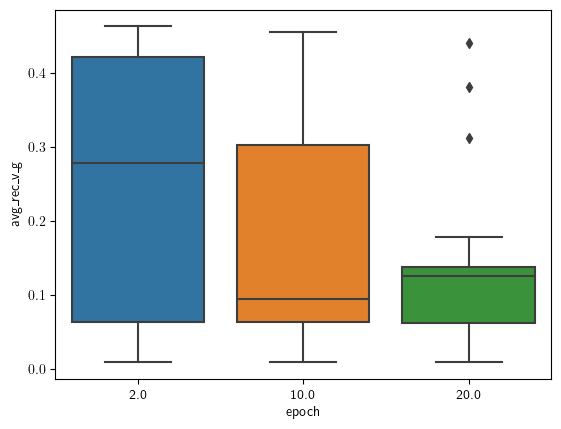

In [78]:
sns.boxplot(data=df_plot, x='epoch', y=c_avg_rec_v_g)

### plot_hyp_search

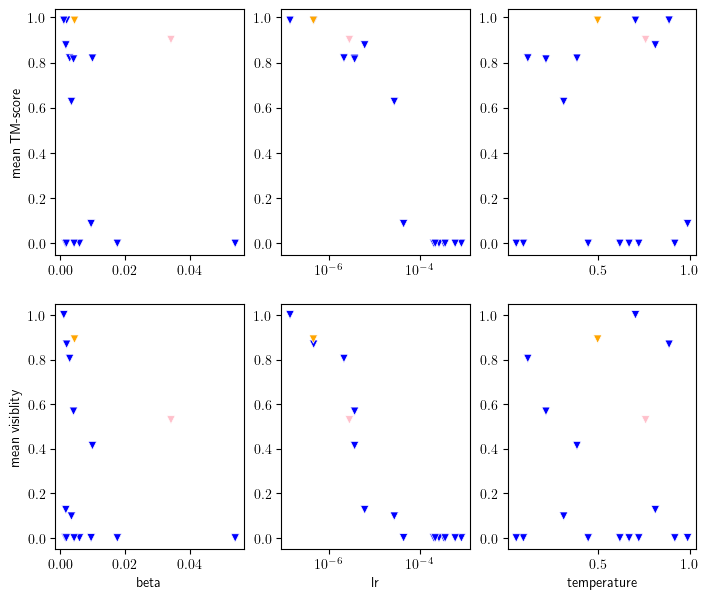

In [79]:
plot_hyp_search(df_plot, [('beta', 'linear'), ('lr', 'log'), ('temperature', 'linear')], [2], save_fig=save_fig)

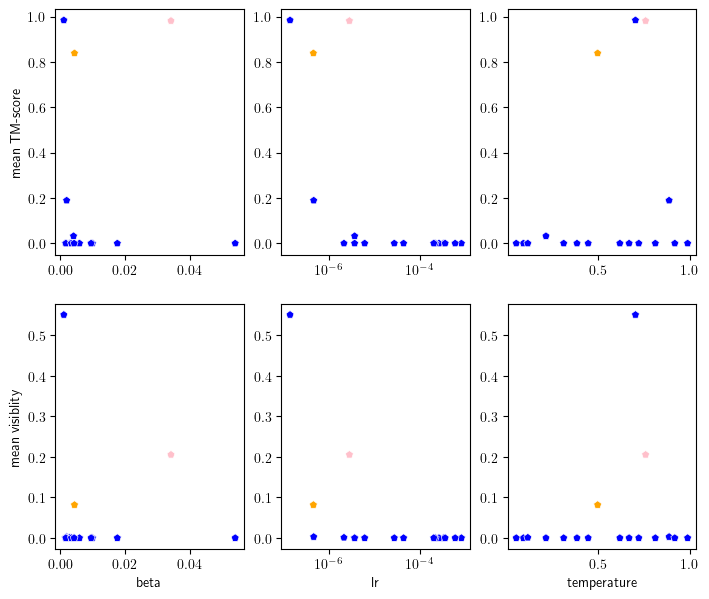

In [80]:
plot_hyp_search(df_plot, [('beta', 'linear'), ('lr', 'log'), ('temperature', 'linear')], [20], save_fig=False)

In [81]:
df_plot.query(f"`{c_avg_tm_v_s}` > 0.9")

,avg_rec_v_g,avg_vis_mhc_1_v_g,avg_vis_mhc_1_pc_v_g,avg_tm_v_s,avg_vis_mhc_1_v_s,avg_vis_mhc_1_v_s_pwm,epoch,beta,lr,temperature,model_id
source,,,,,,,,,,,
78b6cb1a:epoch_10,0.455796,112.714286,0.791258,0.988227,0.779651,0.798513,10.0,0.001191,1.418886e-07,0.703717,78b6cb1a
6f1dbbb0:epoch_2,0.461068,125.452381,0.868441,0.987100,0.871368,0.896363,2.0,0.002057,4.690145e-07,0.885791,6f1dbbb0
e32b8ed0:epoch_2,0.462925,128.404762,0.891320,0.986550,0.876141,0.927479,2.0,0.004483,4.619819e-07,0.499004,e32b8ed0
78b6cb1a:epoch_2,0.461989,142.571429,1.000475,0.986522,0.891922,0.897217,2.0,0.001191,1.418886e-07,0.703717,78b6cb1a
v_48_020,0.462468,149.309524,1.068088,0.986287,0.951998,0.992052,NaN,NaN,NaN,NaN,v_48_020
458340e4:epoch_10,0.389602,36.476190,0.259477,0.985875,0.269547,0.253546,10.0,0.034260,2.855919e-06,0.758613,458340e4
e32b8ed0:epoch_10,0.428029,62.595238,0.453667,0.983807,0.501042,0.504190,10.0,0.004483,4.619819e-07,0.499004,e32b8ed0
78b6cb1a:epoch_20,0.440551,77.500000,0.550991,0.983693,0.574784,0.585170,20.0,0.001191,1.418886e-07,0.703717,78b6cb1a
458340e4:epoch_20,0.380361,28.619048,0.205585,0.981015,0.229899,0.195720,20.0,0.034260,2.855919e-06,0.758613,458340e4


### plot_trade_off

In [82]:
c_avg_vis_mhc_1_pc_v_g_upper_bound = 0.5
c_avg_rec_v_g_lower_bound = 0.30
c_avg_tm_v_s_lower_bound = 0.8
df_plot.query(
    f"`{c_avg_vis_mhc_1_pc_v_g}` < {c_avg_vis_mhc_1_pc_v_g_upper_bound}"
    f" and {c_avg_rec_v_g_lower_bound} < `{c_avg_rec_v_g}` "
    f" and {c_avg_tm_v_s_lower_bound} < `{c_avg_tm_v_s}` "
)

,avg_rec_v_g,avg_vis_mhc_1_v_g,avg_vis_mhc_1_pc_v_g,avg_tm_v_s,avg_vis_mhc_1_v_s,avg_vis_mhc_1_v_s_pwm,epoch,beta,lr,temperature,model_id
source,,,,,,,,,,,
458340e4:epoch_10,0.389602,36.476190,0.259477,0.985875,0.269547,0.253546,10.0,0.034260,2.855919e-06,0.758613,458340e4
e32b8ed0:epoch_10,0.428029,62.595238,0.453667,0.983807,0.501042,0.504190,10.0,0.004483,4.619819e-07,0.499004,e32b8ed0
458340e4:epoch_20,0.380361,28.619048,0.205585,0.981015,0.229899,0.195720,20.0,0.034260,2.855919e-06,0.758613,458340e4
6f1dbbb0:epoch_10,0.392181,43.142857,0.312425,0.964797,0.319947,0.326455,10.0,0.002057,4.690145e-07,0.885791,6f1dbbb0
b5d1eab1:epoch_2,0.318701,18.142857,0.126810,0.877410,0.197017,0.185658,2.0,0.001818,6.178679e-06,0.811254,b5d1eab1
e32b8ed0:epoch_20,0.312681,12.309524,0.081671,0.838210,0.115891,0.128526,20.0,0.004483,4.619819e-07,0.499004,e32b8ed0
3e88d46a:epoch_2,0.421289,57.238095,0.414068,0.818992,0.509152,0.509377,2.0,0.010022,3.715891e-06,0.387107,3e88d46a


In [83]:
ckpt_ids_selected = ["e32b8ed0:epoch_10", "e32b8ed0:epoch_20", "458340e4:epoch_10", "458340e4:epoch_20"]

In [84]:
df_plot.loc[ckpt_ids_selected]

,avg_rec_v_g,avg_vis_mhc_1_v_g,avg_vis_mhc_1_pc_v_g,avg_tm_v_s,avg_vis_mhc_1_v_s,avg_vis_mhc_1_v_s_pwm,epoch,beta,lr,temperature,model_id
source,,,,,,,,,,,
e32b8ed0:epoch_10,0.428029,62.595238,0.453667,0.983807,0.501042,0.504190,10.0,0.004483,4.619819e-07,0.499004,e32b8ed0
e32b8ed0:epoch_20,0.312681,12.309524,0.081671,0.838210,0.115891,0.128526,20.0,0.004483,4.619819e-07,0.499004,e32b8ed0
458340e4:epoch_10,0.389602,36.476190,0.259477,0.985875,0.269547,0.253546,10.0,0.034260,2.855919e-06,0.758613,458340e4
458340e4:epoch_20,0.380361,28.619048,0.205585,0.981015,0.229899,0.195720,20.0,0.034260,2.855919e-06,0.758613,458340e4


In [85]:
sources_to_model_ids(ckpt_ids_selected)

['e32b8ed0', 'e32b8ed0', '458340e4', '458340e4']

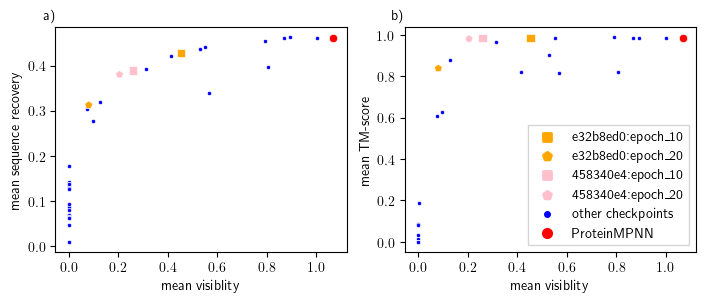

In [86]:
plot_trade_off(df_plot, ckpt_ids_selected, save_fig=save_fig)

In [87]:
tm_min = 0.9
CAPE.Eval.MPNN.plots.tm_min = tm_min

result = {}
for protein_id in protein_splits[Split.VAL]:
    min_vis_ckpt_id = None
    min_vis = 1000.
    
    for ckpt_id in ckpt_ids_hyp:
        if tm_scores[ckpt_id][protein_id] >= tm_min:
            candidate_vis_mhc_1 = vis_mhc_1[ckpt_id][protein_id]
            if candidate_vis_mhc_1 < min_vis:
                min_vis_ckpt_id = ckpt_id
                min_vis = candidate_vis_mhc_1

    result[protein_id] = (min_vis_ckpt_id, min_vis)

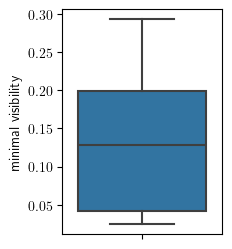

In [88]:
fig = plt.figure(figsize=(A4_width/4, A4_height/4))
ax = fig.add_subplot(1,1,1)

_df = pd.DataFrame({k:[v[1]] for k, v in result.items()}, index=['minimal visibility']).transpose()
sns.boxplot(data=_df, y='minimal visibility', ax=ax)
if save_fig:
    fig.savefig(kit.path.join(G.ENV.ARTEFACTS, "figures", "CAPE-MPNN", G.DOMAIN, f"Figure_C.pdf"), bbox_inches='tight')

# Testing - design all positions

In [89]:
designed_positions_name = 'all'
designed_positions_id = designed_positions_name.replace(" +/- ", "_pm_") 

In [90]:
_protein_ids = protein_splits[Split.TEST]
_source_ids = ckpt_ids_selected + base_model_ids

## generate

In [91]:
call_mpnn(
    protein_splits[Split.TEST], 
    ckpt_ids_selected + base_model_ids, 
    specific_trials, 
    protein_infos, 
    pdb_input_path, 
    fasta_output_path
)

4KW4


  0%|          | 0/5 [00:00<?, ?it/s]

8A6G


  0%|          | 0/5 [00:00<?, ?it/s]

1UBQ


  0%|          | 0/5 [00:00<?, ?it/s]

2QMT


  0%|          | 0/5 [00:00<?, ?it/s]

6QJI


  0%|          | 0/5 [00:00<?, ?it/s]

1M40


  0%|          | 0/5 [00:00<?, ?it/s]

5O75


  0%|          | 0/5 [00:00<?, ?it/s]

7DYA


  0%|          | 0/5 [00:00<?, ?it/s]

1SQ3


  0%|          | 0/5 [00:00<?, ?it/s]

1EUM


  0%|          | 0/5 [00:00<?, ?it/s]

1QAW


  0%|          | 0/5 [00:00<?, ?it/s]

4GYT


  0%|          | 0/5 [00:00<?, ?it/s]

6EHB


  0%|          | 0/5 [00:00<?, ?it/s]

## evaluate

In [92]:
send_to_pdb(ckpt_ids_selected + base_model_ids, protein_splits[Split.TEST], 'all', colabfold_path)

Structures to predict: 0


**Predict structures from sequences:** [Go to explanation](#pdb-generation)

In [93]:
# netMHCpan
db.add_visibility_mhc_1_missing(immuno_setup['mhc_1'])

# pwm
db.add_visibility_mhc_1_missing(mhc_1_setup_hash, mhc_1_predictor=predictor_MHC_I_pwm)

Predicting: 0 sequences


0it [00:00, ?it/s]

Predicting: 0 sequences


0it [00:00, ?it/s]

In [94]:
Design.load_tm_scores(['data'] + _source_ids, _protein_ids)
Design.load_vis_mhc_1(['data'] + _source_ids, _protein_ids, immuno_setup['mhc_1'], predictor_MHC_I_netmhcpan, None)
Design.load_vis_mhc_1(['data'] + _source_ids, _protein_ids, mhc_1_setup_hash, predictor_MHC_I_pwm, None)
Design.load_info(['data', 'data_similar'] + _source_ids, _protein_ids, 'blosum')

best[designed_positions_name] = Design.get_best_trials(
    source_ids=['data'] + _source_ids,
    protein_ids=_protein_ids,
    best_trial=bt, 
    designed_positions='all')

## Results

In [95]:
tm_scores = Design.get_best_tm_scores(best[designed_positions_name])
vis_mhc_1, vis_mhc_1_abs = Design.get_best_mhc_1_vis(best[designed_positions_name], immuno_setup['mhc_1'], predictor_MHC_I_netmhcpan, None)

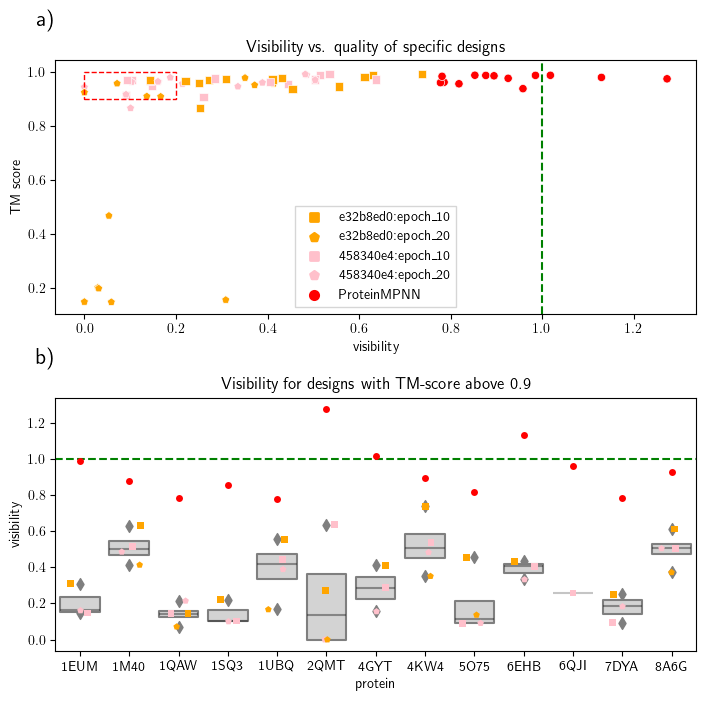

In [96]:
key = (immuno_setup['mhc_1'], predictor_setup['mhc_1'].get_predictor_hash(), None)

save_fig = f"Figure_B_{designed_positions_id}.pdf"
_df = plot_specific(
    _source_ids, 
    _protein_ids,
    best[designed_positions_name],
    ('vis_mhc_1', 'visibility', False, True, key),
    ('tm_scores', 'TM score', False, False),
    min_info_y_value=0.9, 
    save_fig=save_fig
)

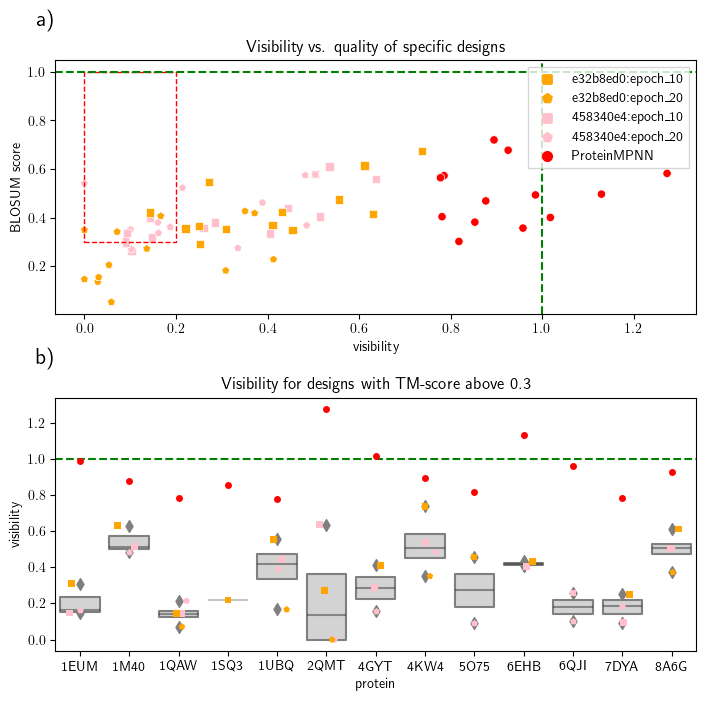

In [97]:
key = (immuno_setup['mhc_1'], predictor_setup['mhc_1'].get_predictor_hash(), None)

_df = plot_specific(
    _source_ids, 
    _protein_ids,
    best[designed_positions_name],
    ('vis_mhc_1', 'visibility', False, True, key),
    ('blosum', 'BLOSUM score', False, True),
    min_info_y_value=0.3
)

## DESTRESS

In [98]:
_destress_dir_path = join(destress_dir_path, str(Split.TEST), designed_positions_id)

# copy pdb files to the DESTRESS folder
missing = cp_pdb_to_dir_path(
    _source_ids, 
    _protein_ids, 
    _destress_dir_path,
    designed_positions=designed_positions_name
)

# run the following command
print(f"python3 run_destress_headless.py --i {_destress_dir_path}")

Found/copied/missing: 195/0/9
[]
python3 run_destress_headless.py --i /media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/CAPE-Eval/CAPE-MPNN/destress/TEST/all


In [99]:
# read the destress results
_ = Design.load_destress(_source_ids, _protein_ids, _destress_dir_path)

## GO

In [100]:
_seq_hashes = [best[designed_positions_name][s][p] for s in _source_ids for p in _protein_ids]
_file_path = join(G.ENV.ARTEFACTS, 'CAPE-MPNN', 'seq_hashes', f'{designed_positions_id}.seq_hash')
kit.loch.seq_hashes_to_file(_seq_hashes, _file_path)

print(f"GO.TransFun.from_hashes {_file_path} {kit.loch.path.LOCH_PATH} AF")

GO.TransFun.from_hashes /media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/CAPE-Eval/CAPE-MPNN/seq_hashes/all.seq_hash /media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/CAPE-MPNN/loch AF


In [101]:
print(f"Before: {len(df_GO_vectors)}")
df_GO_vectors = add_to_GO_vectors(_seq_hashes, 'AF')
print(f"After:  {len(df_GO_vectors)}")

Before: 60
After:  90


# Testing - design around epitopes

In [102]:
designed_positions_name = f'epitope +/- {design_epitope_window}'
designed_positions_id = designed_positions_name.replace(" +/- ", "_pm_") 

## generate

In [103]:
call_mpnn(
    _protein_ids, 
    _source_ids, 
    specific_trials, 
    protein_infos, 
    pdb_input_path, 
    fasta_output_path,
    design_epitope_window=design_epitope_window,
    predictor_setup=predictor_setup,
    immuno_setup=immuno_setup
)

4KW4


  0%|          | 0/5 [00:00<?, ?it/s]

8A6G


  0%|          | 0/5 [00:00<?, ?it/s]

1UBQ


  0%|          | 0/5 [00:00<?, ?it/s]

2QMT


  0%|          | 0/5 [00:00<?, ?it/s]

6QJI


  0%|          | 0/5 [00:00<?, ?it/s]

1M40


  0%|          | 0/5 [00:00<?, ?it/s]

5O75


  0%|          | 0/5 [00:00<?, ?it/s]

7DYA


  0%|          | 0/5 [00:00<?, ?it/s]

1SQ3


  0%|          | 0/5 [00:00<?, ?it/s]

1EUM


  0%|          | 0/5 [00:00<?, ?it/s]

1QAW


  0%|          | 0/5 [00:00<?, ?it/s]

4GYT


  0%|          | 0/5 [00:00<?, ?it/s]

6EHB


  0%|          | 0/5 [00:00<?, ?it/s]

## evaluate

In [104]:
send_to_pdb(_source_ids, _protein_ids, designed_positions_name, colabfold_path)

Structures to predict: 0


**Predict structures from sequences:** [Go to explanation](#pdb-generation)

In [105]:
# netMHCpan
db.add_visibility_mhc_1_missing(immuno_setup['mhc_1'])

# pwm
db.add_visibility_mhc_1_missing(mhc_1_setup_hash, mhc_1_predictor=predictor_MHC_I_pwm)

Predicting: 0 sequences


0it [00:00, ?it/s]

Predicting: 0 sequences


0it [00:00, ?it/s]

In [106]:
Design.load_tm_scores(_source_ids, _protein_ids)
Design.load_vis_mhc_1(_source_ids, _protein_ids, immuno_setup['mhc_1'], predictor_MHC_I_netmhcpan, None)
Design.load_vis_mhc_1(_source_ids, _protein_ids, mhc_1_setup_hash, predictor_MHC_I_pwm, None)
Design.load_info(['data', 'data_similar'] + _source_ids, _protein_ids, 'blosum')

best[designed_positions_name] = Design.get_best_trials(
    source_ids=['data'] + _source_ids,
    protein_ids=_protein_ids,
    best_trial=bt, 
    designed_positions=designed_positions_name)

## DESTRESS

In [107]:
_destress_dir_path = join(destress_dir_path, str(Split.TEST), designed_positions_id)

# copy pdb files to the DESTRESS folder
missing = cp_pdb_to_dir_path(
    _source_ids, 
    _protein_ids, 
    _destress_dir_path,
    designed_positions=designed_positions_name
)

# run the following command
print(f"python3 run_destress_headless.py --i {_destress_dir_path}")

Found/copied/missing: 195/0/16
[]
python3 run_destress_headless.py --i /media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/CAPE-Eval/CAPE-MPNN/destress/TEST/epitope_pm_0


In [108]:
# read the destress results
_ = Design.load_destress(_source_ids, _protein_ids, _destress_dir_path)

## GO

In [109]:
_seq_hashes = [best[designed_positions_name][s][p] for s in _source_ids for p in _protein_ids]
_file_path = join(G.ENV.ARTEFACTS, 'CAPE-MPNN', 'seq_hashes', f'{designed_positions_id}.seq_hash')
kit.loch.seq_hashes_to_file(_seq_hashes, _file_path)

print(f"GO.TransFun.from_hashes {_file_path} {kit.loch.path.LOCH_PATH} AF")

GO.TransFun.from_hashes /media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/CAPE-Eval/CAPE-MPNN/seq_hashes/epitope_pm_0.seq_hash /media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/CAPE-MPNN/loch AF


In [110]:
print(f"Before: {len(df_GO_vectors)}")
df_GO_vectors = add_to_GO_vectors(_seq_hashes, 'AF')
print(f"After:  {len(df_GO_vectors)}")

Before: 90
After:  119


# Testing - design around anchors

In [111]:
designed_positions_name = f'anchors +/- {design_anchors_window}'
designed_positions_id = designed_positions_name.replace(" +/- ", "_pm_") 

## generate

In [112]:
call_mpnn(
    _protein_ids, 
    _source_ids, 
    specific_trials, 
    protein_infos, 
    pdb_input_path, 
    fasta_output_path,
    design_anchor_window=design_anchors_window,
    predictor_setup=predictor_setup,
    immuno_setup=immuno_setup
)

4KW4


  0%|          | 0/5 [00:00<?, ?it/s]

8A6G


  0%|          | 0/5 [00:00<?, ?it/s]

1UBQ


  0%|          | 0/5 [00:00<?, ?it/s]

2QMT


  0%|          | 0/5 [00:00<?, ?it/s]

6QJI


  0%|          | 0/5 [00:00<?, ?it/s]

1M40


  0%|          | 0/5 [00:00<?, ?it/s]

5O75


  0%|          | 0/5 [00:00<?, ?it/s]

7DYA


  0%|          | 0/5 [00:00<?, ?it/s]

1SQ3


  0%|          | 0/5 [00:00<?, ?it/s]

1EUM


  0%|          | 0/5 [00:00<?, ?it/s]

1QAW


  0%|          | 0/5 [00:00<?, ?it/s]

4GYT


  0%|          | 0/5 [00:00<?, ?it/s]

6EHB


  0%|          | 0/5 [00:00<?, ?it/s]

## evaluate

In [113]:
send_to_pdb(_source_ids, _protein_ids, designed_positions_name, colabfold_path)

Structures to predict: 0


**Predict structures from sequences:** [Go to explanation](#pdb-generation)

In [114]:
# netMHCpan
db.add_visibility_mhc_1_missing(immuno_setup['mhc_1'])

# pwm
db.add_visibility_mhc_1_missing(mhc_1_setup_hash, mhc_1_predictor=predictor_MHC_I_pwm)

Predicting: 0 sequences


0it [00:00, ?it/s]

Predicting: 0 sequences


0it [00:00, ?it/s]

In [115]:
Design.load_tm_scores(_source_ids, _protein_ids)
Design.load_vis_mhc_1(_source_ids, _protein_ids, immuno_setup['mhc_1'], predictor_MHC_I_netmhcpan, None)
Design.load_vis_mhc_1(_source_ids, _protein_ids, mhc_1_setup_hash, predictor_MHC_I_pwm, None)
Design.load_info(['data', 'data_similar'] + _source_ids, _protein_ids, 'blosum')

best[designed_positions_name] = Design.get_best_trials(
    source_ids=['data'] + _source_ids,
    protein_ids=_protein_ids,
    best_trial=bt, 
    designed_positions=designed_positions_name)

## DESTRESS

In [116]:
_destress_dir_path = join(destress_dir_path, str(Split.TEST), designed_positions_id)

# copy pdb files to the DESTRESS folder
missing = cp_pdb_to_dir_path(
    _source_ids, 
    _protein_ids, 
    _destress_dir_path,
    designed_positions=designed_positions_name
)

# run the following command
print(f"python3 run_destress_headless.py --i {_destress_dir_path}")

Found/copied/missing: 195/0/0
[]
python3 run_destress_headless.py --i /media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/CAPE-Eval/CAPE-MPNN/destress/TEST/anchors_pm_0


In [117]:
# read the destress results
_ = Design.load_destress(_source_ids, _protein_ids, _destress_dir_path)

## GO

In [118]:
_seq_hashes = [best[designed_positions_name][s][p] for s in _source_ids for p in _protein_ids]
_file_path = join(G.ENV.ARTEFACTS, 'CAPE-MPNN', 'seq_hashes', f'{designed_positions_id}.seq_hash')
kit.loch.seq_hashes_to_file(_seq_hashes, _file_path)

print(f"GO.TransFun.from_hashes {_file_path} {kit.loch.path.LOCH_PATH} AF")

GO.TransFun.from_hashes /media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/CAPE-Eval/CAPE-MPNN/seq_hashes/anchors_pm_0.seq_hash /media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/CAPE-MPNN/loch AF


In [119]:
print(f"Before: {len(df_GO_vectors)}")
df_GO_vectors = add_to_GO_vectors(_seq_hashes, 'AF')
print(f"After:  {len(df_GO_vectors)}")

Before: 119
After:  149


# Results

## Overview

In [120]:
index = pd.MultiIndex.from_product([
    _source_ids,
    _protein_ids,
    list(best.keys())
], names=['source_id', 'protein_id', 'designed_positions'])

df_results = pd.DataFrame(index=index)

In [121]:
for designed_positions_name, _best in best.items():
    designed_positions_id = designed_positions_name.replace(" +/- ", "_pm_") 

    tm_scores = Design.get_best_tm_scores(_best)
    mhc_1_vis, _ = Design.get_best_mhc_1_vis(_best, immuno_setup['mhc_1'], predictor_setup['mhc_1'], None)
    
    for source_id in _source_ids:
        for protein_id in _protein_ids:
            df_results.loc[(source_id, protein_id, designed_positions_name), "vis_mhc_1"] = mhc_1_vis[source_id][protein_id]
            df_results.loc[(source_id, protein_id, designed_positions_name), "tm_score"] = tm_scores[source_id][protein_id]

In [122]:
stats = ['mean', 'min', 'max']
stats = ['mean']

In [123]:
### CAPE-MPNN
grouped = df_results.query(f'source_id not in {base_model_ids}')\
    .groupby(level='designed_positions').agg({
    'vis_mhc_1': stats,
    'tm_score': stats,
})

grouped.loc[['all', 'epitope +/- 0', 'anchors +/- 0']]

,vis_mhc_1,tm_score
,mean,mean
designed_positions,,
all,0.281743,0.871561
epitope +/- 0,0.297005,0.877647
anchors +/- 0,0.345259,0.964400


In [124]:
### CAPE-MPNN for specific protein
selected_protein_id = '1EUM'
grouped = df_results.query(f'source_id not in {base_model_ids} and protein_id == "{selected_protein_id}"')\
    .groupby(level=['designed_positions', 'protein_id']).agg({
    'vis_mhc_1': stats,
    'tm_score': stats,
})

grouped.loc[['all', 'epitope +/- 0', 'anchors +/- 0']]

,,vis_mhc_1,tm_score
,,mean,mean
designed_positions,protein_id,,
all,1EUM,0.169118,0.758127
epitope +/- 0,1EUM,0.161765,0.744885
anchors +/- 0,1EUM,0.312500,0.944445


In [125]:
### ProteinMPNN
grouped = df_results.query(f'source_id in {base_model_ids}')\
    .groupby(level='designed_positions').agg({
    'vis_mhc_1': stats,
    'tm_score': stats,
})

grouped.loc[['all', 'epitope +/- 0', 'anchors +/- 0']]

,vis_mhc_1,tm_score
,mean,mean
designed_positions,,
all,0.928947,0.974290
epitope +/- 0,0.796346,0.975175
anchors +/- 0,0.768275,0.975408


## Figures

### Figure B

In [126]:
def _plot_specific(execute, designed_positions_name, save_plot):
    if execute:
        designed_positions_id = designed_positions_name.replace(" +/- ", "_pm_")
        
        save_fig = None
        if save_plot:
            save_fig = f"Figure_B_{designed_positions_id}.pdf"

        _best = best[designed_positions_name]
        key = (immuno_setup['mhc_1'], predictor_setup['mhc_1'].get_predictor_hash(), None)
        _df = plot_specific(
            _source_ids, 
            _protein_ids,
            _best,
            ('vis_mhc_1', 'visibility', False, True, key),
            ('tm_scores', 'TM score', False, True),
            min_info_y_value=0.9, 
            save_fig=save_fig
        )
    else:
        print("")

interact(_plot_specific, 
         execute=False,
         designed_positions_name=list(best.keys()),
         save_plot=False
)

interactive(children=(Checkbox(value=False, description='execute'), Dropdown(description='designed_positions_n…

<function __main__._plot_specific(execute, designed_positions_name, save_plot)>

### Figure D

In [128]:
_infos_off = ['blosum']

def _overview(execute, designed_positions_name, **kwargs):
    save_plot = kwargs['save_plot']
    _infos_to_plot = {k: v for k, v in infos_to_plot.items() if kwargs[k]}
    if execute:
        designed_positions_id = designed_positions_name.replace(" +/- ", "_pm_") 
        _save_fig = None
        if save_plot:
            _save_fig = f'Figure_D_{designed_positions_id}.pdf' if save_fig else None

        plot_infos(_source_ids, 
                   sorted(_protein_ids), 
                   best[designed_positions_name], 
                   _infos_to_plot, 
                   show_background_range=similar_min_count,
                   save_fig=_save_fig, 
                   wspace=0.1, hspace=0.1, plot_good=False
        )
    else:
        print("")

interact(_overview, 
         execute=False,
         designed_positions_name=list(best.keys()),
         **{k: True if k not in _infos_off else False for k in infos_to_plot.keys()},
         save_plot=False
)

interactive(children=(Checkbox(value=False, description='execute'), Dropdown(description='designed_positions_n…

<function __main__._overview(execute, designed_positions_name, **kwargs)>

In [142]:
best['all']['458340e4:epoch_20']['1UBQ']

'3525edda7a8e941d1b60d213c7db86961f11026093c73aab498e522782131be1'

In [ ]:
Design.designs['data']['1UBQ'].seqs

In [126]:
Design.designs['data']['1UBQ'].seqs

{'233b4b0b8c4616095bc3249f9375fc345d32af7deaef07117d0383c51d6f19aa': 'MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG'}

## Deep Dive

In [126]:
def deep_dive_sequence(source_id, protein_id, best, 
                       proteome_hash=None,
                       show_structures=False,
                       show_blosum=False
                      ):
    design = Design.designs[source_id][protein_id]
    seq_hash = best[source_id][protein_id]
    if seq_hash is None:
        print(f"MISSING: {source_id} {protein_id}")
        return None
    seq = design.seqs[seq_hash]
    vis_mhc_1_abs = design.vis_mhc_1_abs[(immuno_setup['mhc_1'],predictor_setup['mhc_1'].get_predictor_hash(), proteome_hash)]
    vis = vis_mhc_1_abs[seq_hash] if seq_hash in vis_mhc_1_abs else "NA"

    seq_data = None
    if show_blosum:
        seq_hash_data = design.get_seq_hash_data()
        seq_data = design.data.seqs[seq_hash_data]

    design.print(seq_hash, infos_to_plot)
    
    print_seq(
        seq, 
        name=f'{protein_id} - {source_id}',
        info=f'TM-score: {design.tm_scores[seq_hash]:.2f}, Vis: {vis}<br>{seq_hash}',
        line_breaks=100,
        #spaces=0,
        immuno_setup=immuno_setup, 
        predictor_setup=predictor_setup,
        ref_seq=seq_data
    )
    if show_structures:
        pred = 'exp' if source_id.startswith('data') else 'AF'
        view_structure(seq_hash, width=400, height=400,
                      predictor_structure_name=pred)


def print_sequences(source_ids, protein_ids, best):
    for protein_id in protein_ids:
        for source_id in source_ids:
            deep_dive_sequence(source_id, protein_id, best)

In [127]:
# from https://alphafold.ebi.ac.uk/faq#faq-12
# pLDDT
# How confident should I be in a prediction?
# AlphaFold produces a per-residue estimate of its confidence on a scale from 0 - 100. This confidence measure is called pLDDT and corresponds to the model’s predicted score on the lDDT-Cα metric. It is stored in the B-factor fields of the mmCIF and PDB files available for download (although unlike a B-factor, higher pLDDT is better). pLDDT is also used to colour-code the residues of the model in the 3D structure viewer. The following rules of thumb provide guidance on the expected reliability of a given region:
#     Regions with pLDDT > 90 are expected to be modelled to high accuracy. These should be suitable for any application that benefits from high accuracy (e.g. characterising binding sites).
#     Regions with pLDDT between 70 and 90 are expected to be modelled well (a generally good backbone prediction).
#     Regions with pLDDT between 50 and 70 are low confidence and should be treated with caution.
#     The 3D coordinates of regions with pLDDT < 50 often have a ribbon-like appearance and should not be interpreted. We show in our paper that pLDDT < 50 is a reasonably strong predictor of disorder, i.e. it suggests such a region is either unstructured in physiological conditions or only structured as part of a complex. (Note: this relationship has typically been tested in the context of well-studied proteins, which may have more evolutionarily-related sequences available than a randomly chosen UniProt entry.)
#     Structured domains with many inter-residue contacts are likely to be more reliable than extended linkers or isolated long helices.
#     Unphysical bond lengths and clashes do not usually appear in confident regions. Any part of a structure with several of these should be disregarded.
# Note that the PDB and mmCIF files contain coordinates for all regions, regardless of their pLDDT score. It is up to the user to interpret the model judiciously, in accordance with the guidance above.



def get_expected_AF_accuracy(seq_hash):
    prefix_file_path = os.path.join(colabfold_path, 'output', seq_hash)

    for i in range(1, 6):
        score_file_path = f'{prefix_file_path}_scores_rank_001_alphafold2_multimer_v3_model_{i}_seed_000.json'
        if os.path.exists(score_file_path):
            break

    if not os.path.exists(score_file_path):
        return None 
        
    # alignment_error_file_path = f'{prefix_file_path}_predicted_aligned_error_v1.json'
    with open(score_file_path, 'r') as file:
        plddt = json.load(file)['plddt']

    high, well, caution, ribbon, cnt = 0, 0, 0, 0, 0
    for v in plddt:
        if v > 90:
            high += 1
        elif v > 70:
            well += 1
        elif v > 50:
            caution += 1
        else:
            ribbon += 1
        cnt += 1
        
    return {
        'high': high/cnt,
        'well': well/cnt,
        'caution': caution/cnt,
        'ribbon': ribbon/cnt
    }

In [128]:
# interactive functions
def _print_all_sequences(execute, best):
    if execute:
        print_sequences(['data'] + _source_ids, _protein_ids, best)
    else:
        print("")


interact(_print_all_sequences, 
         execute=False,
         best=best
)

interactive(children=(Checkbox(value=False, description='execute'), Dropdown(description='best', options={'all…

<function __main__._print_all_sequences(execute, best)>

### single design

In [129]:
def _deep_dive(execute, source_id, protein_id, best):
    if execute:
        print(f"{protein_id}: {protein_infos[protein_id][0]}")
        print(f"AF confidence: {get_expected_AF_accuracy(best[source_id][protein_id])}")
        print(Design.designs[source_id][protein_id].dssp[best[source_id][protein_id]])
        print(Design.designs['data'][protein_id].dssp[best["data"][protein_id]])
        
        plot_spider_seq_aa_dist_gen_data_base(source_id, protein_id, base_model_name, best)
        
        deep_dive_sequence(source_id, protein_id, best, show_structures=True, show_blosum=True)
        deep_dive_sequence('data', protein_id, best, show_structures=True)
    else:
        print("")

interact(_deep_dive, 
         execute=False,
         source_id=[s for s in _source_ids if s != 'data'], 
         protein_id=_protein_ids,
         best=best
)

interactive(children=(Checkbox(value=False, description='execute'), Dropdown(description='source_id', options=…

<function __main__._deep_dive(execute, source_id, protein_id, best)>

## Model aa bias

In [130]:
def _show_model_bias(execute, ckpt_id_selected):
    if execute:
        _df = db.sql_to_df(f"""
            SELECT l.source, s.seq 
            FROM lists l LEFT JOIN sequences s ON l.seq_hash == s.seq_hash 
            WHERE l.grp == 'general:VAL'
        """)
        
        n_cols = 1
        n_rows = 3
        fig = plt.figure(figsize=(A4_width, n_rows*A4_height/4))
        gs = mpl.gridspec.GridSpec(
            n_rows,
            n_cols, 
            height_ratios=[1]*n_rows, 
            width_ratios=[1]*n_cols,
            wspace=0.3, hspace=0.3)
        
        source = 'data'
        aa_cnts = calc_seq_aa_cnts(_df.query(f"source == '{source}'").seq, standardize=True, aggregate=True)
        aa_cnts = {a: aa_cnts[a] for a in AA1_STD}
        df_data = pd.DataFrame(aa_cnts, index=[source]).transpose()

        source = base_model_name
        aa_cnts = calc_seq_aa_cnts(_df.query(f"source == '{source}'").seq, standardize=True, aggregate=True)
        aa_cnts = {a: aa_cnts[a] for a in AA1_STD}
        df_base = pd.DataFrame(aa_cnts, index=[source]).transpose()

        source = ckpt_id_selected
        aa_cnts = calc_seq_aa_cnts(_df.query(f"source == '{source}'").seq, standardize=True, aggregate=True)
        aa_cnts = {a: aa_cnts[a] for a in AA1_STD}
        df_selected = pd.DataFrame(aa_cnts, index=[source]).transpose()
        
        plot_aa_dist(df_data, area=gs[0,:])
        plot_aa_dist(pd.concat([df_base, df_data], axis=1), area=gs[1,:])
        plot_aa_dist(pd.concat([df_selected, df_data], axis=1), area=gs[2,:])

interact(_show_model_bias, 
         execute=False,
         ckpt_id_selected=ckpt_ids_selected
)

interactive(children=(Checkbox(value=False, description='execute'), Dropdown(description='ckpt_id_selected', o…

<function __main__._show_model_bias(execute, ckpt_id_selected)>

## Phylogenetic tree

In [131]:
from Bio import Phylo

from kit.bioinf.sf import SequenceFrame
from kit.bioinf.alignment.sequence import MultipleSequenceAligner
from kit.loch.utils import get_seq_hash

2024-08-22 13:09:54:  START: Muscle: muscle -align /tmp/tmp6dbypo8q/input.fa -output /tmp/tmp6dbypo8q/output.afa
2024-08-22 13:09:54:  STOP: Muscle: muscle -align /tmp/tmp6dbypo8q/input.fa -output /tmp/tmp6dbypo8q/output.afa (00:00:00) Muscle finished
2024-08-22 13:09:54:  Calculating distances using blosum62
2024-08-22 13:09:54:  Finished calculating distances
2024-08-22 13:09:54:  START: Muscle: muscle -align /tmp/tmpms7ae2h9/input.fa -output /tmp/tmpms7ae2h9/output.afa
2024-08-22 13:09:55:  STOP: Muscle: muscle -align /tmp/tmpms7ae2h9/input.fa -output /tmp/tmpms7ae2h9/output.afa (00:00:00) Muscle finished
2024-08-22 13:09:55:  Calculating distances using blosum62
2024-08-22 13:09:55:  Finished calculating distances
2024-08-22 13:09:55:  START: Muscle: muscle -align /tmp/tmplqmyhbp0/input.fa -output /tmp/tmplqmyhbp0/output.afa
2024-08-22 13:09:55:  STOP: Muscle: muscle -align /tmp/tmplqmyhbp0/input.fa -output /tmp/tmplqmyhbp0/output.afa (00:00:00) Muscle finished
2024-08-22 13:09:55:

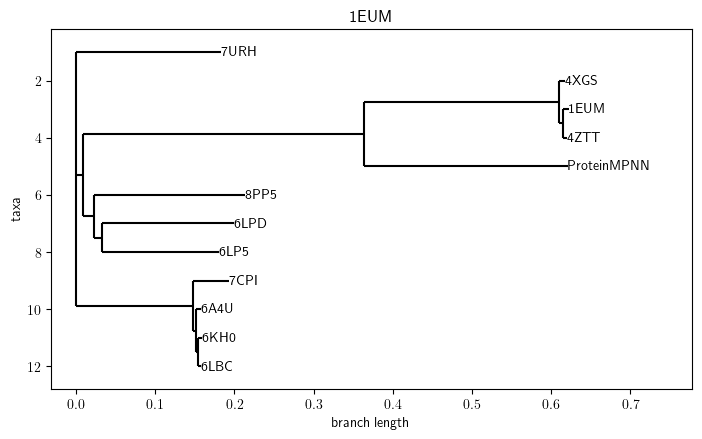

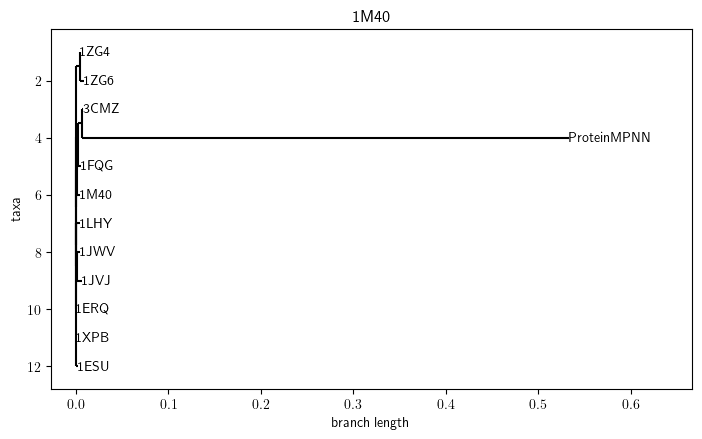

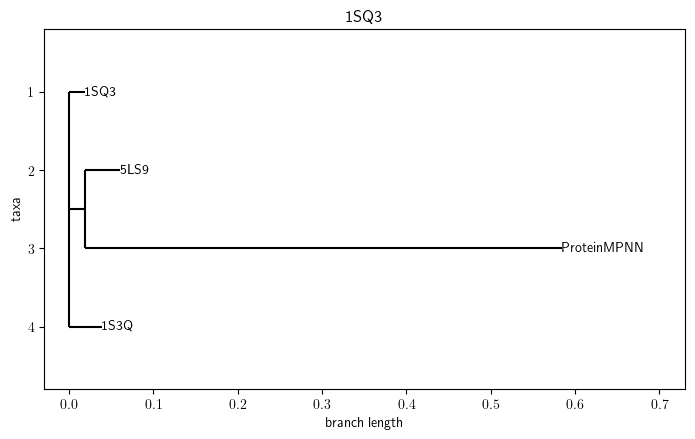

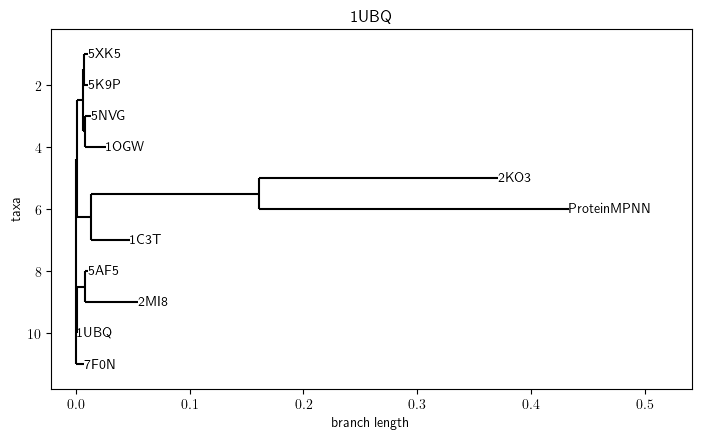

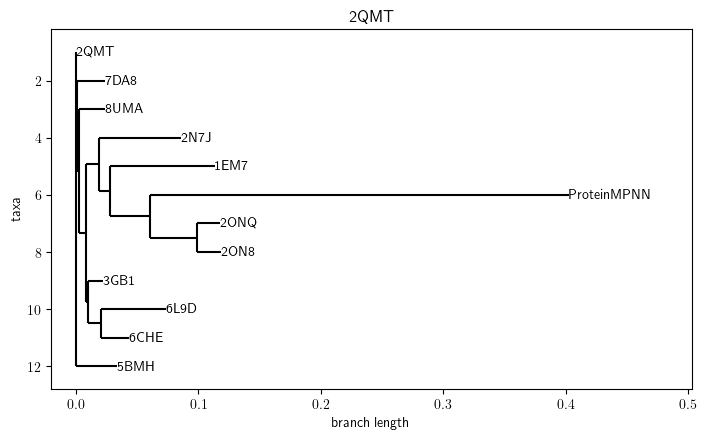

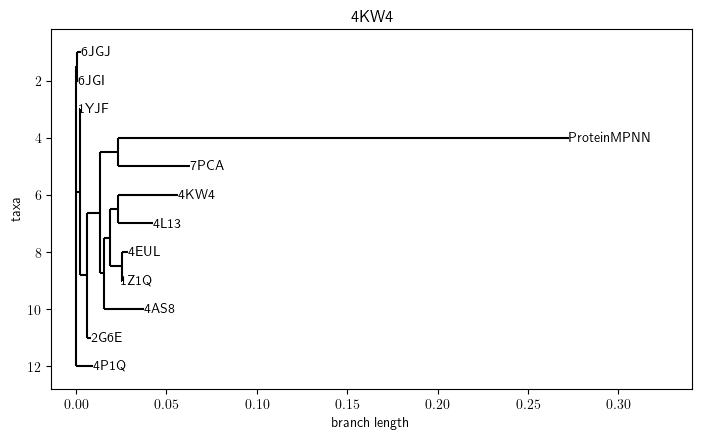

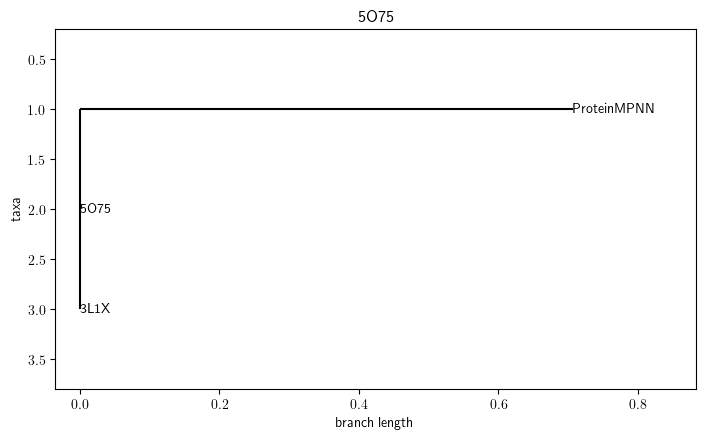

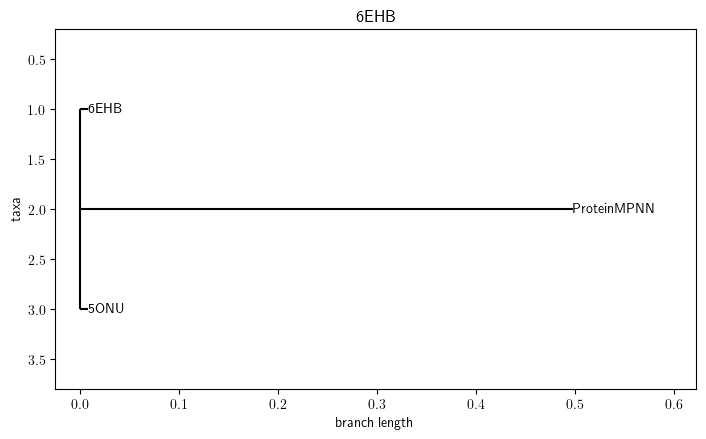

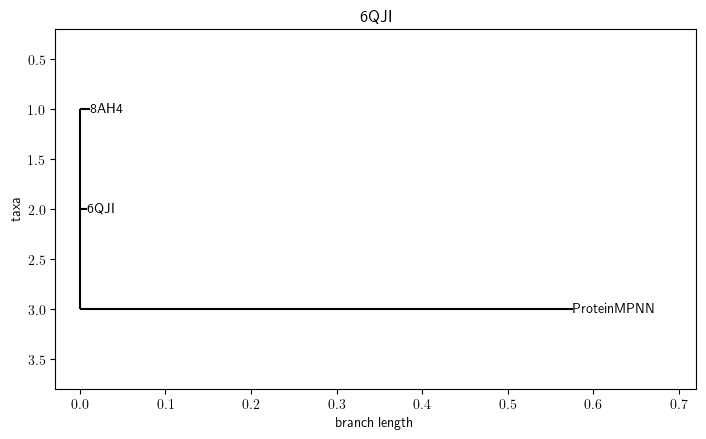

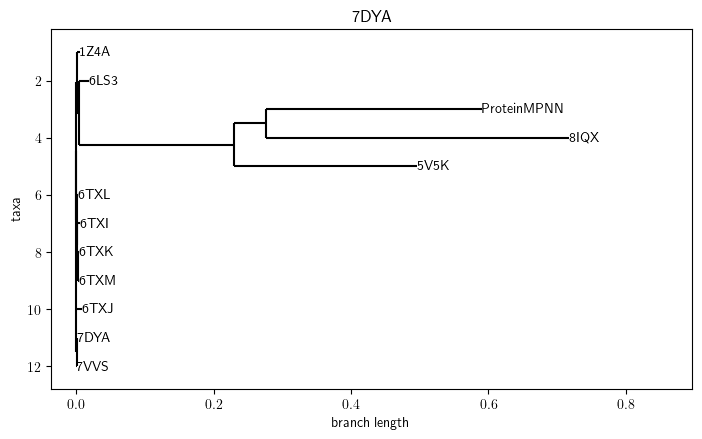

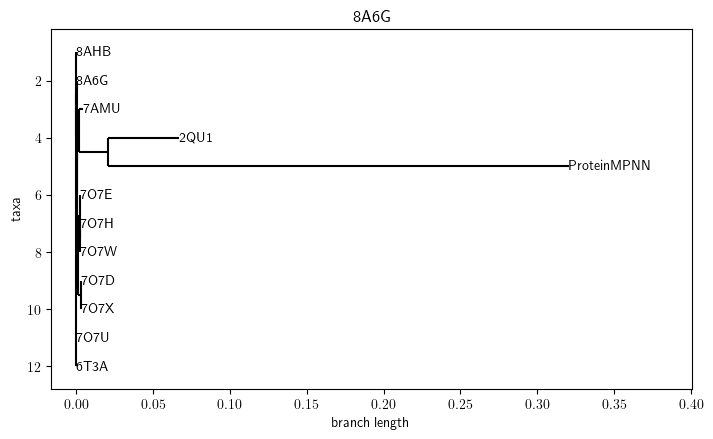

In [132]:
leave_names = {}
for pdb_id, design in Design.designs['data_similar'].items():
    data_design = Design.designs['data'][pdb_id]
    model_design = Design.designs['v_48_020'][pdb_id]

    data_seq = data_design.get_info_data("seqs").split('/')[0]
    data_seq_hash = get_seq_hash(data_seq)
    model_seq = model_design.seqs[best['all']['v_48_020'][pdb_id]].split('/')[0]
    model_seq_hash = get_seq_hash(model_seq)

    _similar_structures = {}
    seqs = [data_seq, model_seq]
    for seq_similar in design.seqs.values():
        seq = seq_similar.split('/')[0]
        _similar_structures[get_seq_hash(seq)] = similar_structures[pdb_id][get_seq_hash(seq_similar)][0]
        seqs.append(seq)

    seqs = [seq.split('/')[0] for seq in seqs]

    sf = SequenceFrame()
    sf.from_seqs(seqs)

    msa = MultipleSequenceAligner(sf)
    msa.align()

    for i, h in enumerate(msa.msa):
        if h.id == data_seq_hash:
            h.id = pdb_id
        elif h.id == model_seq_hash:
            h.id = "ProteinMPNN"
        else:  # h.id in similar_structures[pdb_id]:
            h.id = _similar_structures[h.id]

    tree = msa.construct_phylogenetic_tree(method='plot', do_show=False)

    for clade in tree.find_clades():
        if clade.is_terminal():  # Skip terminal nodes (leaf nodes)
            continue
        clade.name = None  # Remove the label for inner nodes

    fig = plt.figure(figsize=(A4_width, 0.4*A4_height))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(pdb_id)
    Phylo.draw(tree, axes=ax, do_show=False)
    fig.savefig(join(G.ENV.ARTEFACTS, "figures", "CAPE-MPNN", G.DOMAIN, "phylo", f"phylo_{pdb_id}.pdf"), bbox_inches='tight')

In [133]:
h

SeqRecord(seq=Seq('----TDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...T--'), id='7O7D', name='5b17a8be5f2d557b3651d23fd720d2e8ce007e0937a8ac9c4633888be5d0ff2e', description='5b17a8be5f2d557b3651d23fd720d2e8ce007e0937a8ac9c4633888be5d0ff2e', dbxrefs=[])

In [134]:
similar_structures[pdb_id]

{'82eea840415c1ec008a23c8054528399344c94eb2d551108c64d0fe442c62c98': ('7O7E',
  0.99778,
  'HHHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLXXXVLCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNLYIMADKQKNGIKSNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSKLSKDPNEKRDHMVLLEFVTAAGIT'),
 '994ee5eb943d0879d89b1dfb0830cd54406dd21a50dc43b8bf5a662dec50a27a': ('7O7X',
  0.99465,
  'HHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLXXXVLCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNAYIMADKQKNGIKSNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSKLSKDPNEKRDHMVLLEFVTAAGITL'),
 'f61b2386db6c8885c21de70e48bef1ce7373043e2aff22737da392b2e953d193': ('7AMU',
  0.99248,
  'HHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLXXXVLCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKSNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSAQSKLSKDPNEKRDHMVLLEFVTAAGITL'),
 

In [135]:
print(msa.msa)

Alignment with 12 rows and 240 columns
--HHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...TLG 8AHB
--HHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...TL- 7O7X
-ASHPDPFVQKGLALFAGVVPIKVKLDGDVNGHKFSVEGEGEGD...P-- ProteinMPNN
-HHHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...TLG 7O7W
-----AIAXSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...TH- 2QU1
-HHHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...T-- 7O7E
HHHHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...TLG 7O7U
-HHHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...TLG 6T3A
-HHHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...T-- 8A6G
HHHHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...TL- 7O7H
--HHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...TL- 7AMU
----TDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...T-- 7O7D


In [136]:
print(msa.msa[0].seq)

--HHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLXXXVLCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKSNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSKLSKDPNEKRDHMVLLEFVTAAGITLG


In [137]:
print(msa.msa)

Alignment with 12 rows and 240 columns
--HHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...TLG 8AHB
--HHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...TL- 7O7X
-ASHPDPFVQKGLALFAGVVPIKVKLDGDVNGHKFSVEGEGEGD...P-- ProteinMPNN
-HHHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...TLG 7O7W
-----AIAXSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...TH- 2QU1
-HHHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...T-- 7O7E
HHHHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...TLG 7O7U
-HHHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...TLG 6T3A
-HHHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...T-- 8A6G
HHHHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...TL- 7O7H
--HHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...TL- 7AMU
----TDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGD...T-- 7O7D


In [138]:
msa.distance_matrix = None

In [139]:
seqs

['HHHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLXXXVLCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKSNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSKLSKDPNEKRDHMVLLEFVTAAGIT',
 'ASHPDPFVQKGLALFAGVVPIKVKLDGDVNGHKFSVEGEGEGDARTGTLRLKFICTTGKLPVPWPTLITTLXXXVQCFTRYPEHMLQHDFFKSCMPEGYYQERTIKFENDGTYKTRAKVYFDGDTLVNDIELKGTDFKADGNILGHKLEYSFNPYTVTIYADKEKKGIKSEYTLEYKLKDGSTQKAKVEEKVTPIGDGPVLLPEPHKLDHTVKLSKDPNEKRDHMVVDETTVASGIP',
 'HHHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLXXXVLCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNLYIMADKQKNGIKSNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSKLSKDPNEKRDHMVLLEFVTAAGIT',
 'HHTDPMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLXXXVLCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNAYIMADKQKNGIKSNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSKLSKDPNEKRDHMVLLEFVTAAGITL',
 'HHTDPMVSKGEELFTGVVPILVELDGDVNG

# Statistics

## Proteins

In [140]:
calc_full_protein_statistics = False

In [141]:
if calc_full_protein_statistics:
    _all_seqs = {}
    
    
    data_loaders_pdb = get_data_loaders_pdb(
        data_path, 
        [Split.TRAIN, Split.VAL, Split.TEST], 
        general_args.rescut, 
        general_args.debug
    )
    
    data_sets_structure = get_structure_data_sets(
        data_loaders_pdb, 
        100000, 
        general_args.num_examples_per_epoch, 
        general_args.multithreading
    )
    
    data_loaders_structure = {
        split: StructureLoader(
                data_sets_structure[split], 
                batch_size=general_args.batch_size
        ) for split in [Split.TRAIN, Split.VAL, Split.TEST]
    }
    
    for split in [Split.TRAIN, Split.VAL, Split.TEST]:
        for batch in tqdm(data_loaders_structure[split]):
            if len(batch) > 0:
                X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, \
                            visible_list_list, masked_list_list, masked_chain_length_list_list, \
                            chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, \
                            tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, \
                            bias_by_res_all, tied_beta = tied_featurize(batch, kit.DEVICE, None)
        
                names = [b['name'] for b in batch]
                
                batch_size = S.shape[0]
                for b in range(batch_size):
                    seq = _S_to_seq(S[b], mask[b])
                    _all_seqs[names[b]] = seq

<Axes: ylabel='Count'>

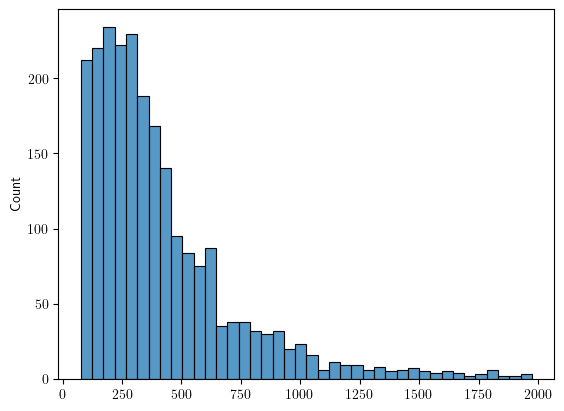

In [142]:
# show the distribution of sequences in the data
sns.histplot([len(seq) for seq in _all_seqs.values()])

In [143]:
aa_cnts = calc_seq_aa_cnts(_all_seqs.values(), standardize=True, aggregate=False)
aa_cnts = {a: aa_cnts[a] for a in AA1_STD}
df_aa_probs = pd.DataFrame(aa_cnts, index=list(_all_seqs.keys())).transpose()



entropies, polarities = [], []
for c in df_aa_probs.columns:
    entropy = calc_entropy(list(df_aa_probs.loc[:, c]))
    polar = np.sum([df_aa_probs.loc[aa, c] for aa in AA_CHARACTERISTICS_2a['polar']])

    entropies.append(entropy)
    polarities.append(polar)

df_protein_stats = pd.DataFrame({
    'entropy': entropies,
    'polarity': polarities,
    'length': [len(_all_seqs[c]) for c in df_aa_probs.columns]
}, index=[x.split('_')[0] for x in df_aa_probs.columns])

<Axes: xlabel='length', ylabel='entropy'>

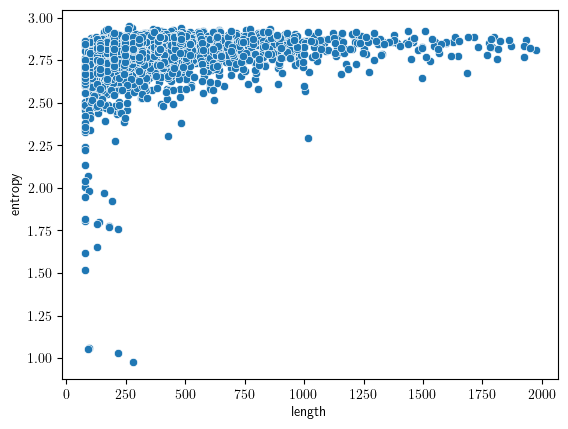

In [144]:
sns.scatterplot(df_protein_stats, x='length', y='entropy')

<Axes: ylabel='Density'>

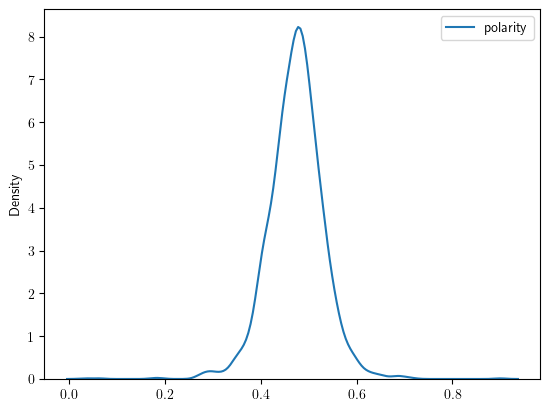

In [145]:
sns.kdeplot(df_protein_stats[['polarity']])

In [146]:
df_protein_stats.describe(percentiles=[0.001, 0.005, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995, 0.999])

,entropy,polarity,length
count,2321.000000,2321.000000,2321.000000
mean,2.774897,0.473361,414.321413
std,0.145673,0.057411,313.148242
min,0.975817,0.032609,77.000000
0.1%,1.054290,0.181266,77.000000
0.5%,1.801834,0.290607,77.000000
1%,2.240684,0.317746,77.000000
10%,2.659010,0.405405,130.000000
25%,2.738039,0.441176,201.000000
50%,2.804624,0.475410,325.000000


## MHC specificity

In [147]:
tmp_args = predictor_MHC_I_dd_args
tmp_args['limit'] = 0.02
pred_mhc_1_tmp = Mhc1Predictor.get_predictor(predictor_MHC_I_pwm_dd.PREDICTOR_MHC_I.NAME)(**tmp_args)

2024-08-22 13:10:00:  Init <class 'kit.bioinf.immuno.mhc_1._pwm.Mhc1PredictorPwm'> MHC-Class1 predictor


In [148]:
for mhc_allele in immuno_setup['mhc_1'].split('+') + ['HLA-A*01:01', 'HLA-A*03:01', 'HLA-B*27:02', 'HLA-B*58:01']:
    print(mhc_allele)
    pred_mhc_1_tmp.PWMs[mhc_allele] = {}
    for l in kit.bioinf.immuno.mhc_1.MHC_1_PEPTIDE_LENGTHS:
        pred_mhc_1_tmp.load_allele(mhc_allele, l)
        pred_mhc_1_tmp.PWMs[mhc_allele][l] = np.exp(pred_mhc_1_tmp.PWMs_log[mhc_allele][l])

HLA-A*02:01
HLA-A*24:02
HLA-B*07:02
HLA-B*39:01
HLA-C*07:01
HLA-C*16:01
HLA-A*01:01
HLA-A*03:01
HLA-B*27:02
HLA-B*58:01


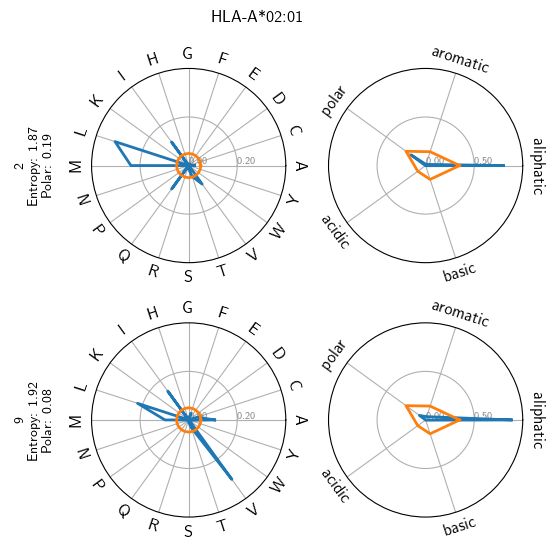

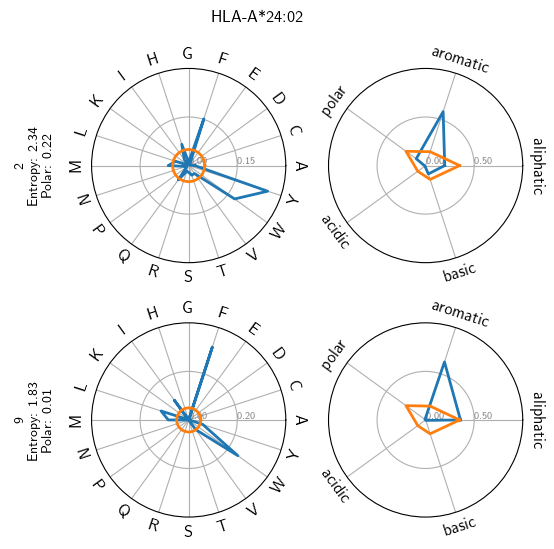

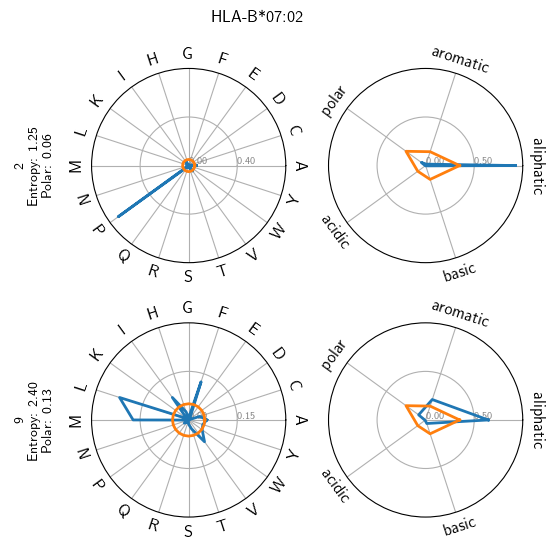

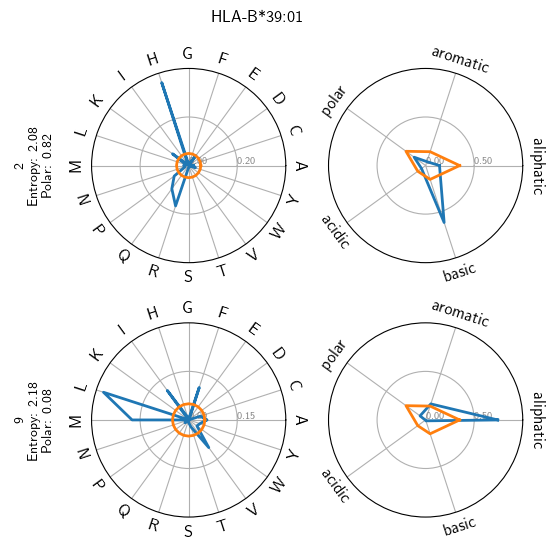

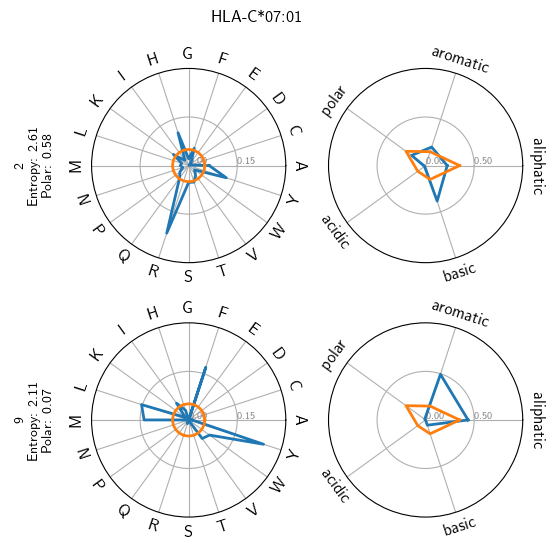

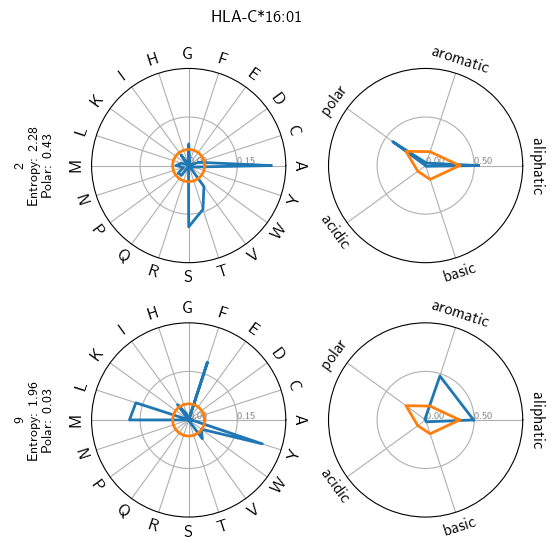

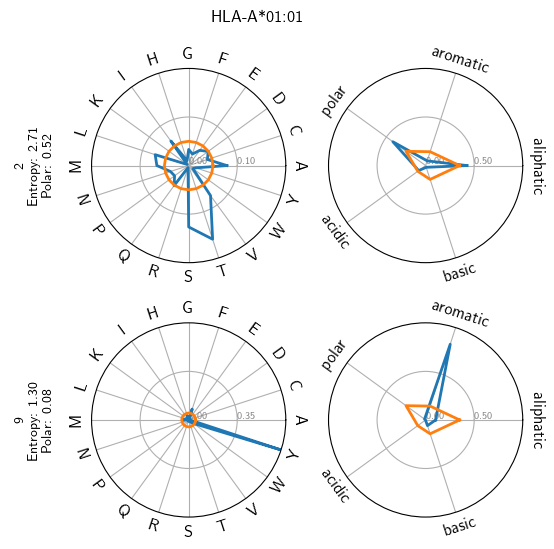

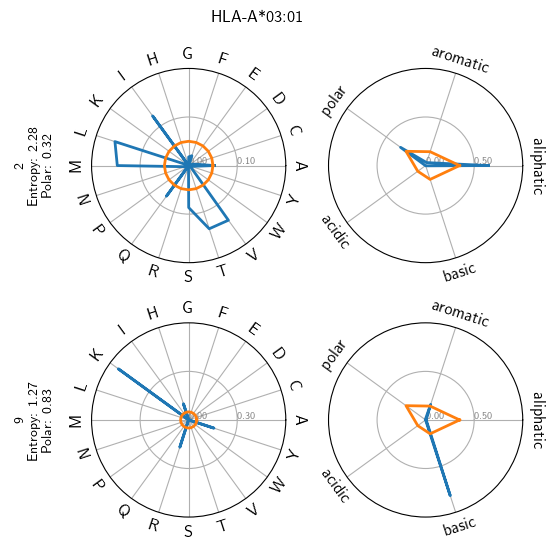

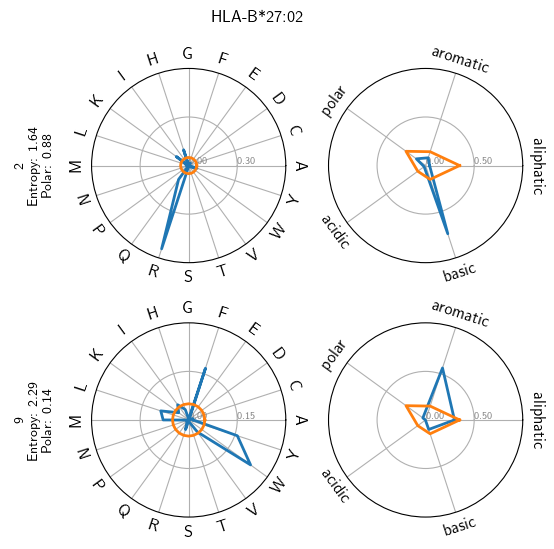

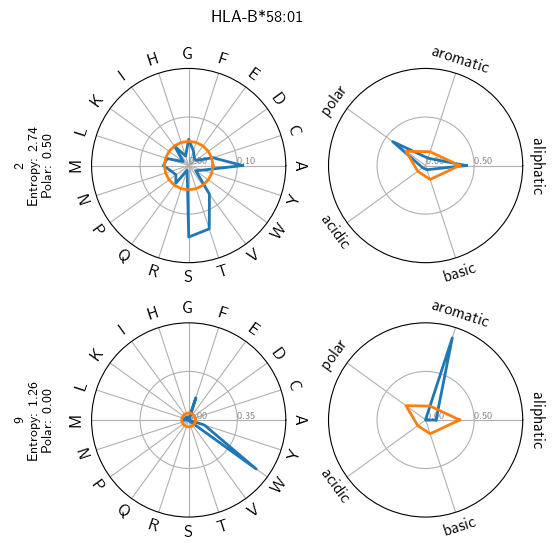

In [149]:
p_len = 9
_epitope_positions = [2, 9]  # range(1, 10)

for mhc_allele in immuno_setup['mhc_1'].split('+') + ['HLA-A*01:01', 'HLA-A*03:01', 'HLA-B*27:02', 'HLA-B*58:01']:
    df_pwm = pd.DataFrame(pred_mhc_1_tmp.PWMs[mhc_allele][p_len], index=[aa for aa in AA1_STD], columns=range(1, p_len+1))
    plot_pwm_dist(df_pwm, _epitope_positions, title=mhc_allele) # [1, -1])

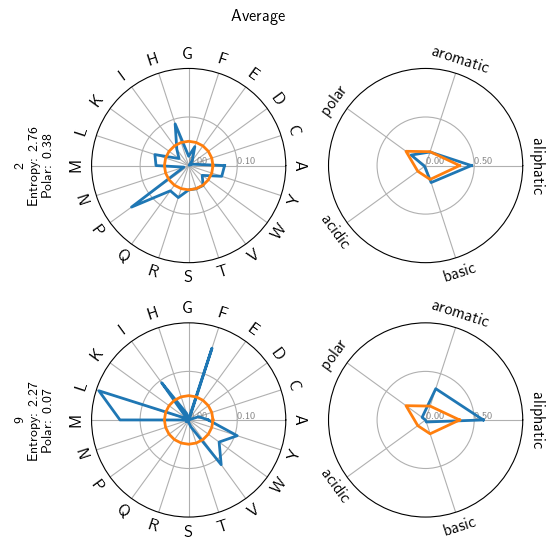

In [150]:
p_len = 9
avg_pwm = np.stack([pred_mhc_1_tmp.PWMs[mhc_allele][p_len] for mhc_allele in immuno_setup['mhc_1'].split('+')])
avg_pwm = np.average(avg_pwm, axis=0)
df_avg_pwm = pd.DataFrame(avg_pwm, index=[aa for aa in AA1_STD], columns=range(1, p_len+1))
plot_pwm_dist(df_avg_pwm, _epitope_positions, title='Average') # [1, -1])

In [151]:
kit.bioinf.AA_CHARACTERISTICS_2a['non-polar']

'AGILMPVFWY'

In [152]:
Design.designs['data']['1EUM'].seqs

{'5a857a91590c0edbe0f6d36e7c3e67520720d456304ae3908e54c8dd323d5ebe': 'LKPEMIEKLNEQMNLELYSSLLYQQMSAWCSYHTFEGAAAFLRRHAQEEMTHMQRLFDYLTDTGNLPRINTVESPFAEYSSLDELFQETYKHEQLITQKINELAHAAMTNQDYPTFNFLQWYVSEQHEEEKLFKSIIDKLSLAGKSGEGLYFIDKELSTLD/LKPEMIEKLNEQMNLELYSSLLYQQMSAWCSYHTFEGAAAFLRRHAQEEMTHMQRLFDYLTDTGNLPRINTVESPFAEYSSLDELFQETYKHEQLITQKINELAHAAMTNQDYPTFNFLQWYVSEQHEEEKLFKSIIDKLSLAGKSGEGLYFIDKELSTLD/LKPEMIEKLNEQMNLELYSSLLYQQMSAWCSYHTFEGAAAFLRRHAQEEMTHMQRLFDYLTDTGNLPRINTVESPFAEYSSLDELFQETYKHEQLITQKINELAHAAMTNQDYPTFNFLQWYVSEQHEEEKLFKSIIDKLSLAGKSGEGLYFIDKELSTLD/LKPEMIEKLNEQMNLELYSSLLYQQMSAWCSYHTFEGAAAFLRRHAQEEMTHMQRLFDYLTDTGNLPRINTVESPFAEYSSLDELFQETYKHEQLITQKINELAHAAMTNQDYPTFNFLQWYVSEQHEEEKLFKSIIDKLSLAGKSGEGLYFIDKELSTLD/LKPEMIEKLNEQMNLELYSSLLYQQMSAWCSYHTFEGAAAFLRRHAQEEMTHMQRLFDYLTDTGNLPRINTVESPFAEYSSLDELFQETYKHEQLITQKINELAHAAMTNQDYPTFNFLQWYVSEQHEEEKLFKSIIDKLSLAGKSGEGLYFIDKELSTLD/LKPEMIEKLNEQMNLELYSSLLYQQMSAWCSYHTFEGAAAFLRRHAQEEMTHMQRLFDYLTDTGNLPRINTVESPFAEYSSLDELFQETYKHEQLITQKINELAHAAMTNQDYPTFNFLQ

In [153]:
get_pdb_file_path('5a857a91590c0edbe0f6d36e7c3e67520720d456304ae3908e54c8dd323d5ebe', predictor_structure_name='exp')

'/media/thoth/FILES/study/ed/PhD/projects/cape/artefacts/CAPE-MPNN/loch/structures/exp/pdb/5a857a91590c0edbe0f6d36e7c3e67520720d456304ae3908e54c8dd323d5ebe_exp.pdb'

# Alternative sampling

In [154]:
ckpt_id_selected = '458340e4:epoch_20'
preference_sampling_methods = [
    'B_B_D_all+C_B_1_epitopes',
    'C_B_D_all+C_B_1_epitopes',
    'B_B_D_epitopes+C_B_1_epitopes',
    'C_B_D_epitopes+C_B_1_epitopes',
]

preference_sampling_methods = [
    '[B_B_D_all+C_B_1_epitopes;50][B_B_D_all+C_B_1_nepitopes;50]',
    '[C_B_D_all+C_B_1_epitopes;50][C_B_D_all+C_B_1_nepitopes;50]',
    '[B_B_D_epitopes+C_B_1_epitopes;25][B_B_D_epitopes+C_B_1_nepitopes;25][B_B_D_nepitopes+C_B_1_epitopes;25][B_B_D_nepitopes+C_B_1_nepitopes;25]',
    '[C_B_D_epitopes+C_B_1_epitopes;25][C_B_D_epitopes+C_B_1_nepitopes;25][C_B_D_nepitopes+C_B_1_epitopes;25][C_B_D_nepitopes+C_B_1_nepitopes;25]',
    '[C_B_D_all+C_B_1_epitopes;50][D_B_D_all+C_B_1_nepitopes;50]',
    '[C_B_D_all+C_B_1_epitopes;25][C_B_D_all+C_B_1_nepitopes;25][D_B_D_all+C_B_1_epitopes;25][D_B_D_all+C_B_1_nepitopes;25]',
    '[C_B_D_all+C_B_1_single;100]',
    '[D_B_D_all+C_B_1_single;100]',
    '[D_B_D_all+C_B_1_single;50][C_B_D_all+C_B_1_single;50]',
]

In [155]:
df_ckpt_selected_details = df_ckpts.loc[[ckpt_id_selected]].join(df_models_hyp, on='model_id', rsuffix='_model')
assert len(df_ckpt_selected_details) == 1
df_ckpt_selected_details.transpose()

ckpt_id,458340e4:epoch_20
model_id,458340e4
success,True
epoch,20
job_id,qf9xm
success_model,True
mhc_1_alleles,b69bb1
proteome_file_name,None
base_model_name,v_48_020
reload_data_every_n_epochs,2
preference_sampling_method,None


In [156]:
for preference_sampling_method in preference_sampling_methods:    
    details = DD.from_dict(dict(df_ckpt_selected_details.iloc[0]))
    details.preference_sampling_method = preference_sampling_method
    argument = f"fix_{details.model_id}_psm_{str_to_hash(preference_sampling_method, 5)}"
    print(argument)
    if write_yamls:
        write_config_yaml(details, argument)
        write_job_yaml(argument)

fix_458340e4_psm_87c1c
fix_458340e4_psm_4a422
fix_458340e4_psm_0e797
fix_458340e4_psm_060d7
fix_458340e4_psm_c0885
fix_458340e4_psm_57803
fix_458340e4_psm_24bc0
fix_458340e4_psm_f1379
fix_458340e4_psm_6c8ef


In [157]:
# in kubernetes Train networks

In [158]:
alternative_sampling_ckpt_ids = get_ckpt_ids(df_models_alternative_sampling, successful_ckpts=True, successful_models=True)

In [159]:
alternative_sampling_ckpt_ids

['9a2f06c7:epoch_2',
 '9a2f06c7:epoch_10',
 '9a2f06c7:epoch_20',
 '7658c3ce:epoch_2',
 '7658c3ce:epoch_10',
 '7658c3ce:epoch_20',
 '4c05ad54:epoch_2',
 '4c05ad54:epoch_10',
 '4c05ad54:epoch_20',
 '4a49ecf4:epoch_2',
 '4a49ecf4:epoch_10',
 '4a49ecf4:epoch_20',
 '2a67fc01:epoch_2',
 '2a67fc01:epoch_10',
 '2a67fc01:epoch_20',
 '9ea98014:epoch_2',
 '9ea98014:epoch_10',
 '9ea98014:epoch_20',
 'bd491cfd:epoch_2',
 'bd491cfd:epoch_10',
 'bd491cfd:epoch_20']

In [160]:
_ckpts, _base_model_ids = load_CapeMPNN_ckpts(alternative_sampling_ckpt_ids)
ckpts.update(_ckpts)
base_model_ids = list(set(base_model_ids) | _base_model_ids)

## How?

In [161]:
splits = [Split.VAL]


data_loaders_pdb = get_data_loaders_pdb(
    data_path, 
    splits, 
    general_args.rescut, 
    general_args.debug
)

data_sets_structure = get_structure_data_sets(
    data_loaders_pdb, 
    100000, 
    general_args.num_examples_per_epoch, 
    general_args.multithreading
)

data_loaders_structure = {
    split: StructureLoader(
            data_sets_structure[split], 
            batch_size=general_args.batch_size
    ) for split in splits
}


In [162]:
binding_aa = 'MLIFYWV'

window = 0
alphabet = 'ACDEFGHIKLMNPQRSTVWYX'

temperature = 1.

In [163]:
_ckpt_ids = [_ckpt_id for _ckpt_id in alternative_sampling_ckpt_ids + [ckpt_id_selected] if 'epoch_20' in _ckpt_id]
_ckpt_ids

['9a2f06c7:epoch_20',
 '7658c3ce:epoch_20',
 '4c05ad54:epoch_20',
 '4a49ecf4:epoch_20',
 '2a67fc01:epoch_20',
 '9ea98014:epoch_20',
 'bd491cfd:epoch_20',
 '458340e4:epoch_20']

In [164]:
_ckpt_ids = ['4c05ad54:epoch_20']

In [165]:
all_log_probs = {
    _ckpt_id: {
        'base_within': [],
        'base_outside': [],
        'cape_within': [],
        'cape_outside': []
    } for _ckpt_id in _ckpt_ids
}

In [166]:
n_batches = 200
dfs_log_probs = {}
for split in splits:
    for n, batch in tqdm(enumerate(data_loaders_structure[split])):            
        if len(batch) > 0:
            X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, \
                        visible_list_list, masked_list_list, masked_chain_length_list_list, \
                        chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, \
                        tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, \
                        bias_by_res_all, tied_beta = tied_featurize(batch, kit.DEVICE, None)
    
            names = [b['name'] for b in batch]
            
            batch_size = S.shape[0]

            positions_outside, positions_within, AAs_selected, batch_nr = [], [], [], []
            mask_outside = torch.zeros_like(mask)
            mask_within = torch.zeros_like(mask)
            for b in range(batch_size):
                # _seq = _S_to_seq(S[b], mask[b])
                # _seq = S_to_seq(S[b])
                # _all_seqs[names[b]] = _seq

                mask_positions = set(torch.nonzero(mask[b]).squeeze().numpy())

                seq = batch[b]['seq']
                # assert _seq == seq
                
                positions_epitope, positions_anchors, positions_unknown = \
                                    predictor_setup['mhc_1'].get_presented_positions(
                                        seq, 
                                        immuno_setup['mhc_1'], 
                                        anchors=[-1]
                                    )

                positions_hot = positions_anchors
                
                AAs_outside = defaultdict(lambda: [])
                for p in (set(range(len(seq))) - set(positions_hot)) & mask_positions:
                    AAs_outside[seq[p]].append(p)
                
                AAs_within = defaultdict(lambda: [])
                for p in (set(range(len(seq))) & set(positions_hot)) & mask_positions:
                    AAs_within[seq[p]].append(p)

                aa_to_choose_from = list(set(AAs_outside) & set(AAs_within) & set(binding_aa))
                if len(aa_to_choose_from) > 0:
                    aa_selected = np.random.choice(aa_to_choose_from)
                    pos_outside = np.random.choice(AAs_outside[aa_selected])
                    pos_within = np.random.choice(AAs_within[aa_selected])
                    
                    assert pos_outside not in positions_hot
                    assert pos_within in positions_hot
                    assert seq[pos_outside] == seq[pos_within] == aa_selected

                    c = pos_outside          
                    for w in range(-window, window+1):
                        p = min(max(0, c + w), len(seq))    
                        mask_outside[b, p] = mask[b, p]

                    c = pos_within
                    for w in range(-window, window+1):
                        p = min(max(0, c + w), len(seq))    
                        mask_within[b, p] = mask[b, p]
    
                    positions_outside.append(pos_outside)
                    positions_within.append(pos_within)
                    AAs_selected.append(aa_selected)
                    batch_nr.append(b)
                    
                    
            # print(len(AAs_selected))
            if len(AAs_selected) > 0:   
                B = X.shape[0]
                decoding_order = torch.arange(S.shape[1]).repeat(B, 1).to(kit.DEVICE)
                base_log_probs_outside = ckpts['v_48_020'](
                        X, S, mask_outside, chain_M, residue_idx, chain_encoding_all, decoding_order,
                        omit_AA_mask=omit_AA_mask, temperature=temperature
                )
                base_log_probs_within = ckpts['v_48_020'](
                        X, S, mask_within, chain_M, residue_idx, chain_encoding_all, decoding_order,
                        omit_AA_mask=omit_AA_mask, temperature=temperature
                )

                for _ckpt_id in _ckpt_ids:
                    cape_log_probs_outside = ckpts[_ckpt_id](
                            X, S, mask_outside, chain_M, residue_idx, chain_encoding_all, decoding_order,
                            omit_AA_mask=omit_AA_mask, temperature=temperature
                    )

                    cape_log_probs_within = ckpts[_ckpt_id](
                            X, S, mask_within, chain_M, residue_idx, chain_encoding_all, decoding_order,
                            omit_AA_mask=omit_AA_mask, temperature=temperature
                    )

                    log_probs = all_log_probs[_ckpt_id]
                    for pos_outside, pos_within, aa_selected, b in zip(positions_outside, positions_within, AAs_selected, batch_nr):
                        log_probs['base_within'].append(float(base_log_probs_within[b, pos_within, alphabet.index(aa_selected)]))
                        log_probs['base_outside'].append(float(base_log_probs_outside[b, pos_outside, alphabet.index(aa_selected)]))
        
                        log_probs['cape_within'].append(float(cape_log_probs_within[b, pos_within, alphabet.index(aa_selected)]))
                        log_probs['cape_outside'].append(float(cape_log_probs_outside[b, pos_outside, alphabet.index(aa_selected)]))
                
    
        if n >= n_batches:
            break


0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
for _ckpt_id in _ckpt_ids:
    log_probs = all_log_probs[_ckpt_id]
    df_log_probs = pd.DataFrame(log_probs)
    dfs_log_probs[_ckpt_id] = df_log_probs
    
    model_id, ckpt = _ckpt_id.split(":")
    df_log_probs['diff_within'] = df_log_probs.base_within - df_log_probs.cape_within
    df_log_probs['diff_outside'] = df_log_probs.base_outside - df_log_probs.cape_outside
    df_log_probs['gt'] = df_log_probs.diff_within > df_log_probs.diff_outside
    df_log_probs['diff'] = df_log_probs['diff_within'] - df_log_probs['diff_outside']
    df_log_probs_mean = df_log_probs.mean()

    psm = df_models_all.loc[model_id, 'preference_sampling_method']
    psm = '' if psm is None else psm
    
    print(f"{_ckpt_id:15s}: {df_log_probs_mean['gt']:3.2f} {df_log_probs_mean['diff']:3.2f} {psm:40s}")


In [ ]:
positions_outside = []
positions_within = []
AAs_selected = []

for b in range(batch_size):
    seq = batch[b]['seq']
    positions_epitope, positions_ankers, positions_unknown = \
                        predictor_setup['mhc_1'].get_presented_positions(seq, immuno_setup['mhc_1'])
    
    AAs_outside_epitopes = defaultdict(lambda: [])
    for p in (set(range(len(seq))) - set(positions_epitope)):
        AAs_outside_epitopes[seq[p]].append(p)
    
    AAs_within_epitopes = defaultdict(lambda: [])
    for p in (set(range(len(seq))) & set(positions_epitope)):
        AAs_within_epitopes[seq[p]].append(p)
    
    aa_selected = np.random.choice(list(set(AAs_outside_epitopes) & set(AAs_within_epitopes) & set(kit.bioinf.AA_CHARACTERISTICS_2a['non-polar'])))
    pos_outside = np.random.choice(AAs_outside_epitopes[aa_selected])
    pos_within = np.random.choice(AAs_within_epitopes[aa_selected])
    
    assert pos_outside not in positions_epitope
    assert pos_within in positions_epitope
    assert seq[pos_outside] == seq[pos_within] == aa_selected

    positions_outside.append(pos_outside)
    positions_within.append(pos_within)
    AAs_selected.append(aa_selected)

In [ ]:
sample_dict = ckpts['v_48_020'].sample(X, randn_2, S, chain_M,
                chain_encoding_all, residue_idx,
                mask=mask,
                temperature=temperature,
                omit_AAs_np=OMIT_AAs_NP,
                bias_AAs_np=BIAS_AAs_NP,
                chain_M_pos=chain_M_pos,
                omit_AA_mask=omit_AA_mask,
                bias_by_res=bias_by_res_all)

In [ ]:
B = X.shape[0]
decoding_order = torch.arange(S.shape[1]).repeat(B, 1).to(kit.DEVICE)
base_log_probs = ckpts['v_48_020'](
        X, S, mask, chain_M, residue_idx, chain_encoding_all, decoding_order,
        omit_AA_mask=omit_AA_mask, temperature=temperature
)

In [ ]:
base_log_probs.shape

In [ ]:
likdsajf;ljsfa/0

# pdb generation

## check missing

In [ ]:
file_names = []
done = []
missing = []
for file_name in os.listdir(os.path.join(colabfold_path, 'input')):
    file_names.append(file_name)
    seq_hash = os.path.basename(file_name).removesuffix('.fasta')
    if os.path.exists(os.path.join(colabfold_path, 'output', f"{seq_hash}_pae.png")):
        done.append(seq_hash)
    else:
        missing.append(seq_hash)

print(f"In Queue: {len(file_names)}")
print(f"Done:     {len(done)}")
print(f"Missing:  {len(missing)}")

In [ ]:
for _seq_hash in missing:
    # print(f'cp ./artefacts/CAPE-Eval/colabfold/input/{_seq_hash}.fasta /home/tux/colabfold/input/')
    print(_seq_hash)

## trim to necessary executions

In [ ]:
df_list = db.sql_to_df("SELECT * FROM lists")

In [ ]:
unknown_done = [x for x in done]
for done_seq_hash in done:
    res = df_list.query(f"seq_hash == '{done_seq_hash}'")
    if len(res) > 0:
        unknown_done.remove(done_seq_hash)

print(f"Unknown origin: {len(unknown_done)}")

## run

```
colabfold_batch "${PF}/artefacts/CAPE-Eval/colabfold/input/" "${PF}/artefacts/CAPE-Eval/colabfold/output/" --amber --use-gpu-relax

# Loop through each file matching the pattern
for file in "${PF}/artefacts/CAPE-Eval/colabfold/output/"/*_relaxed_rank_001_*.pdb; do
    if [ -f "$file" ]; then
        # Extract the placeholder name from the file name
        placeholder=$(basename "$file" | cut -d '_' -f 1)
        file_dest="${PF}/artefacts/CAPE-MPNN/loch/structures/AF/pdb/${placeholder}_AF.pdb"
        if [ ! -e "${file_dest}" ]; then
            echo $placeholder
            # Copy the file to the destination directory and rename it
            cp "$file" "${file_dest}"
        fi
    fi
done

```